In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
sp500 = pd.read_csv('sp500.csv')
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.set_index('Date', inplace=True)
sp500 = sp500[(sp500.index.year > 1979)]
sp500['sp500_dr'] = sp500['^GSPC'].pct_change()

{{< pagebreak >}}
#Project Scopet
## Do correlations go to one during crisse?### We do the following: 
1. Identifying Crises: Look at times when the S&P500 drops by a lot (20%) and then recovers by the same amount to mark crisis periods.2. 
Analyzing Correlations: Study how all stocks in the S&P500 move together by checking their correlations. Use data from 20 months to get an idea of this.3. 
Calculating Betas: Figure out the betas by comparing how individual stocks perform compared to the S&P500, considering both direction and volatility. 
 
# Why is This Donehy:
1. "Do correlations go to one during crises" says that the market correlation between all stocks go to one (so average might be one). We take a sample data of SP500 to check that.
2. Since we define a crisis like we do, we need to check correlations with high enough data points to ensure noise reduction but low enough to be contained in a crisis. Hence, we take 20 days of data, which is roughly a month of trading days.

## Our predictions before the result
1. The average correlation should not go to one for our timeframe due to diverse investor sentiment for each industry in the market.
2. Most of the Betas would be around 1 but a very few at exactly 1 due to differing crisis origins.
3. We hope to see higher correlations around the start of the crises owing to negative bias being hard-wired to human nature.
{{< pagebreak >}}
 

In [3]:
new_sp500 = sp500.iloc[:, :-2]

## Crisis Periods

In [4]:
def find_crisis_periods_with_peaks_troughs(df, column_name):
    rolling_max = df[column_name].cummax()
    crisis_periods = []
    peaks_troughs = []
    in_crisis = False
    crisis_start = None
    trough = None
    last_peak = None

    for date, value in df[column_name].items():
        if not in_crisis:
            if value >= rolling_max.loc[date]:
                last_peak = (date)
            
            if value <= rolling_max.loc[date] * 0.8:
                in_crisis = True
                crisis_start = date
                trough = (date,value)
        else:
            if value < trough[1]:
                trough = (date, value)
            
            if value >= trough[1] * 1.2:
                in_crisis = False
                crisis_end = date
                crisis_periods.append((crisis_start, crisis_end))
                peaks_troughs.append((last_peak, trough[0]))
                rolling_max = df.loc[date:][column_name].cummax()

    return crisis_periods, peaks_troughs

crisis_periods, peaks_troughs = find_crisis_periods_with_peaks_troughs(sp500, '^GSPC')

crises = pd.DataFrame(crisis_periods, columns = ['Start date', 'End date'])
peak_trough = pd.DataFrame(peaks_troughs, columns = ['Peak', 'Trough'])

crises

Start date   End date
0 1982-02-22 1982-09-14
1 1987-10-19 1988-03-08
2 2001-03-12 2001-12-05
3 2002-07-10 2002-08-22
4 2008-07-09 2008-12-08
5 2009-02-23 2009-03-23
6 2020-03-12 2020-04-08
7 2022-06-13 2023-06-08

## Here is a graph showcasing crises periods during our entire observation

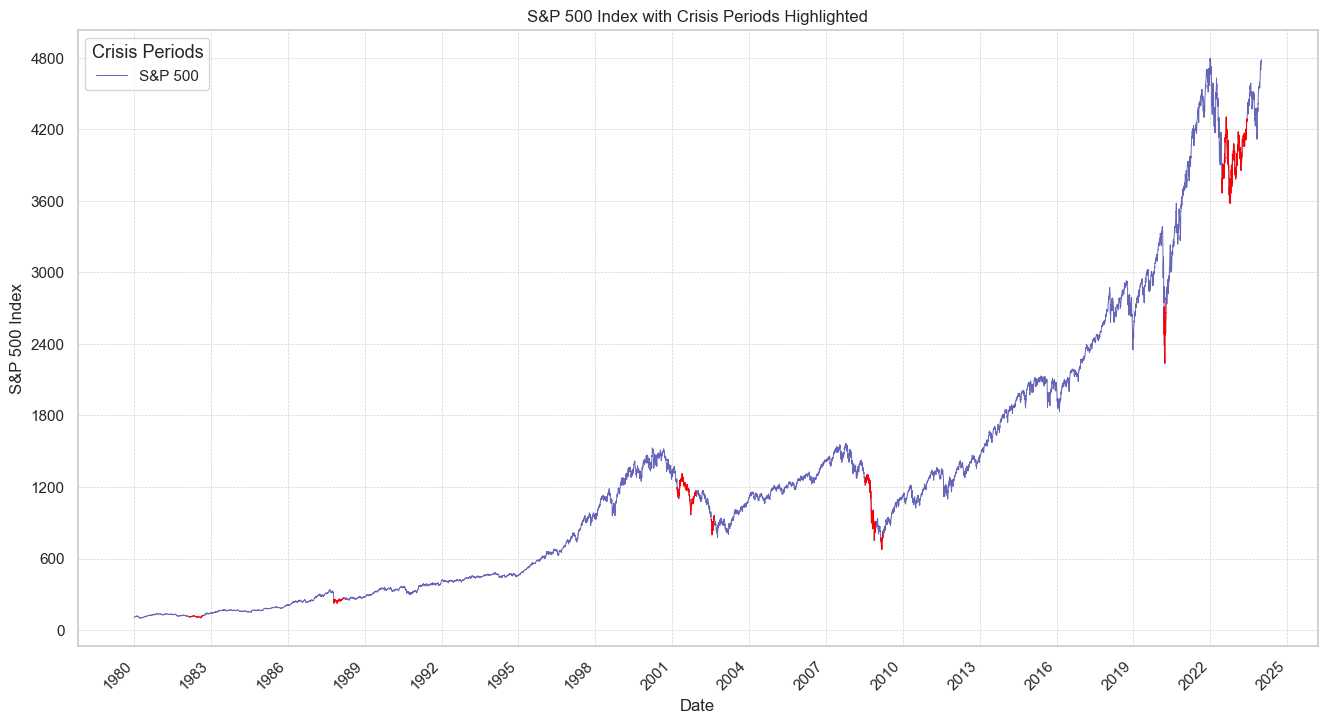

In [5]:
crisis_mask = pd.Series(False, index=sp500.index)
for start, end in crisis_periods:
    crisis_mask |= (sp500.index >= start) & (sp500.index <= end)
    
sns.set(style='whitegrid')
plt.figure(figsize=(16, 8))
plt.plot(sp500.index, sp500['^GSPC'], color='darkblue', label='S&P 500', alpha=0.6, linewidth=0.7)

for start, end in crisis_periods:
    crisis_data = sp500.loc[start:end]
    plt.plot(crisis_data.index, crisis_data['^GSPC'], color='red', linewidth=0.7)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
ax.xaxis.set_minor_locator(mdates.YearLocator(3)) 
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=10))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, ha="right")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.title('S&P 500 Index with Crisis Periods Highlighted')
plt.legend(loc='upper left', title='Crisis Periods', title_fontsize='13', fontsize='11')
plt.show()

{{< pagebreak >}}

### Analysis:
1. Correlations around the time of the crises spikes compared to previous months.
2. Obervation doesn't reveal the average correlation of every stock at 1 although we do see it approaching 1.
3. Since a lot of stocks might also have negative correlations; mean, might not represent the overall picture.

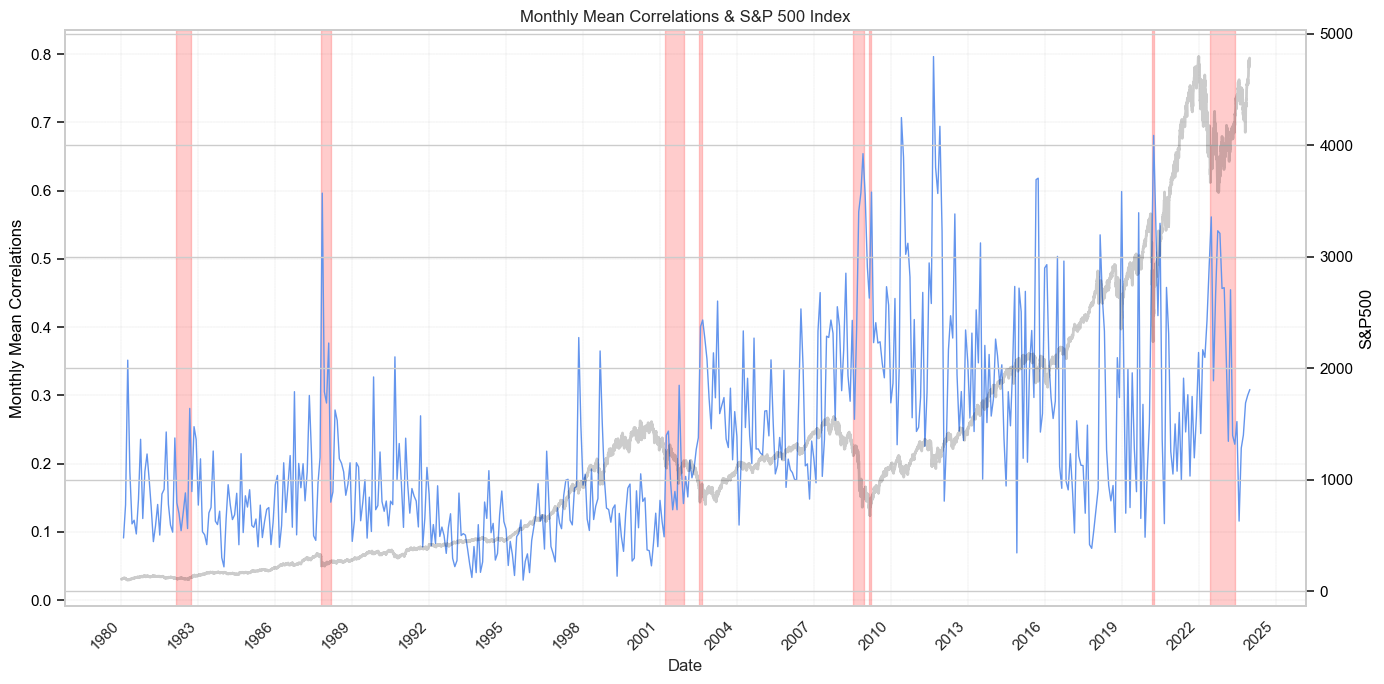

In [6]:
# MEAN
monthly_mean_correlations = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(
    lambda x: x.corr().mask(np.triu(np.ones(x.corr().shape), k=0).astype(bool)).stack().mean())

fig, ax1 = plt.subplots(figsize=(14, 7))

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Mean Correlations', color='black')
ax1.plot(monthly_mean_correlations.index, monthly_mean_correlations, color='cornflowerblue', linewidth=1)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2)
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

plt.title("Monthly Mean Correlations & S&P 500 Index")
plt.tight_layout()
plt.show()



{{< pagebreak >}}
## Monthly Median Correlations analysis
1. We have a lot of data points which would lie around our mean data
2. Median data does not show any noticable difference compared to our mean analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


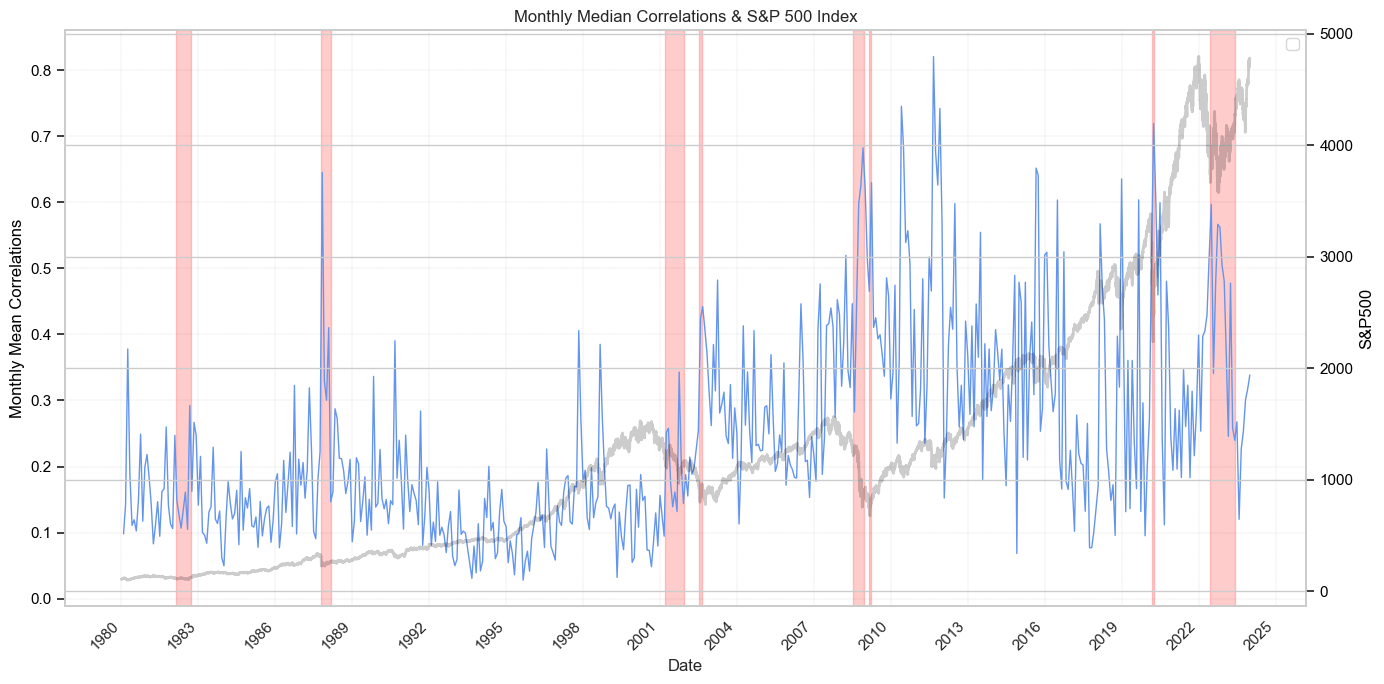

In [7]:
# MEDIAN
monthly_median_correlations = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(
    lambda x: x.corr().mask(np.triu(np.ones(x.corr().shape), k=0).astype(bool)).stack().median())

fig, ax1 = plt.subplots(figsize=(14, 7))

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Mean Correlations', color='black')
ax1.plot(monthly_median_correlations.index, monthly_median_correlations, color='cornflowerblue', linewidth=1, label = "Monthly Correlation")
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2)
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

plt.legend()
plt.title("Monthly Median Correlations & S&P 500 Index")
plt.tight_layout()
plt.show()

{{< pagebreak >}}
## Maximum and Minimum correlations
1. There is a lot of noise in the data but notice maximum and minimum correlations swinging up and down in unison. We believe this is the effect of market sentiment either being bullish or bearish. 
2. As expected, we see at least one pair of stocks having a perfect correlation (positive or negative) in 2 - 3 months for a period of 20 days.
3. Roughly after 2005, the data for maximum showcases at least one pair having perfect correlation, explained by having almost 400 sample stocks compared to previous periods which had less than that, in a complete set of 503.
4. A noticable spike in 2013 can be explained by "[taper tantrum](https://www.investopedia.com/terms/t/taper-tantrum.asp)" when fed chair hinted thier intention to winding down the program of buying government bonds in open market (quatitative easing) which was started after GFC of 2008. This should result in reduced money in market, leading to outflow from the market. The max correlation is capped to 1 but minimum shoots for correlation of 0 showing same trend in the market.

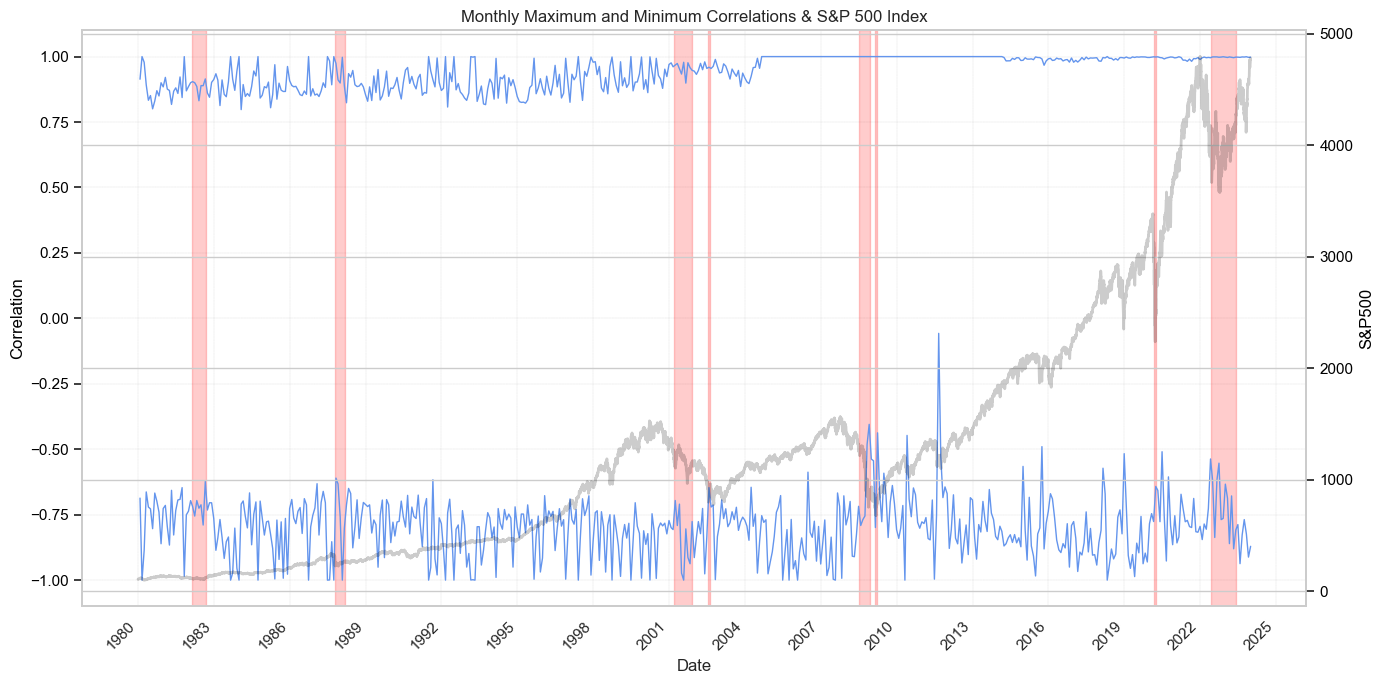

In [8]:
# MAX
monthly_correlations_max = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(
    lambda x: x.corr().mask(np.triu(np.ones(x.corr().shape), k=0).astype(bool)).stack().max())

# MIN
monthly_correlations_min = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(
    lambda x: x.corr().mask(np.triu(np.ones(x.corr().shape), k=0).astype(bool)).stack().min())

fig, ax1 = plt.subplots(figsize=(14, 7))

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Correlation', color='black')
ax1.plot(monthly_correlations_max.index, monthly_correlations_max, color='cornflowerblue', linewidth=1)
ax1.plot(monthly_correlations_min.index, monthly_correlations_min, color='cornflowerblue', linewidth=1)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2)
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

plt.title("Monthly Maximum and Minimum Correlations & S&P 500 Index")
plt.tight_layout()
plt.show()

## Standard deviation and covariance
1. Since we see a lot of noise in the data we try to examine the noise by plotting standard deviation and covariance.
2. Standard deviation proves our initial assumption that crisis starts in a panic sell by market participants but spike in covariance shows, regardless of the varying industries among SP500, the whole market sentiment is bearish; leading to higher correlations.

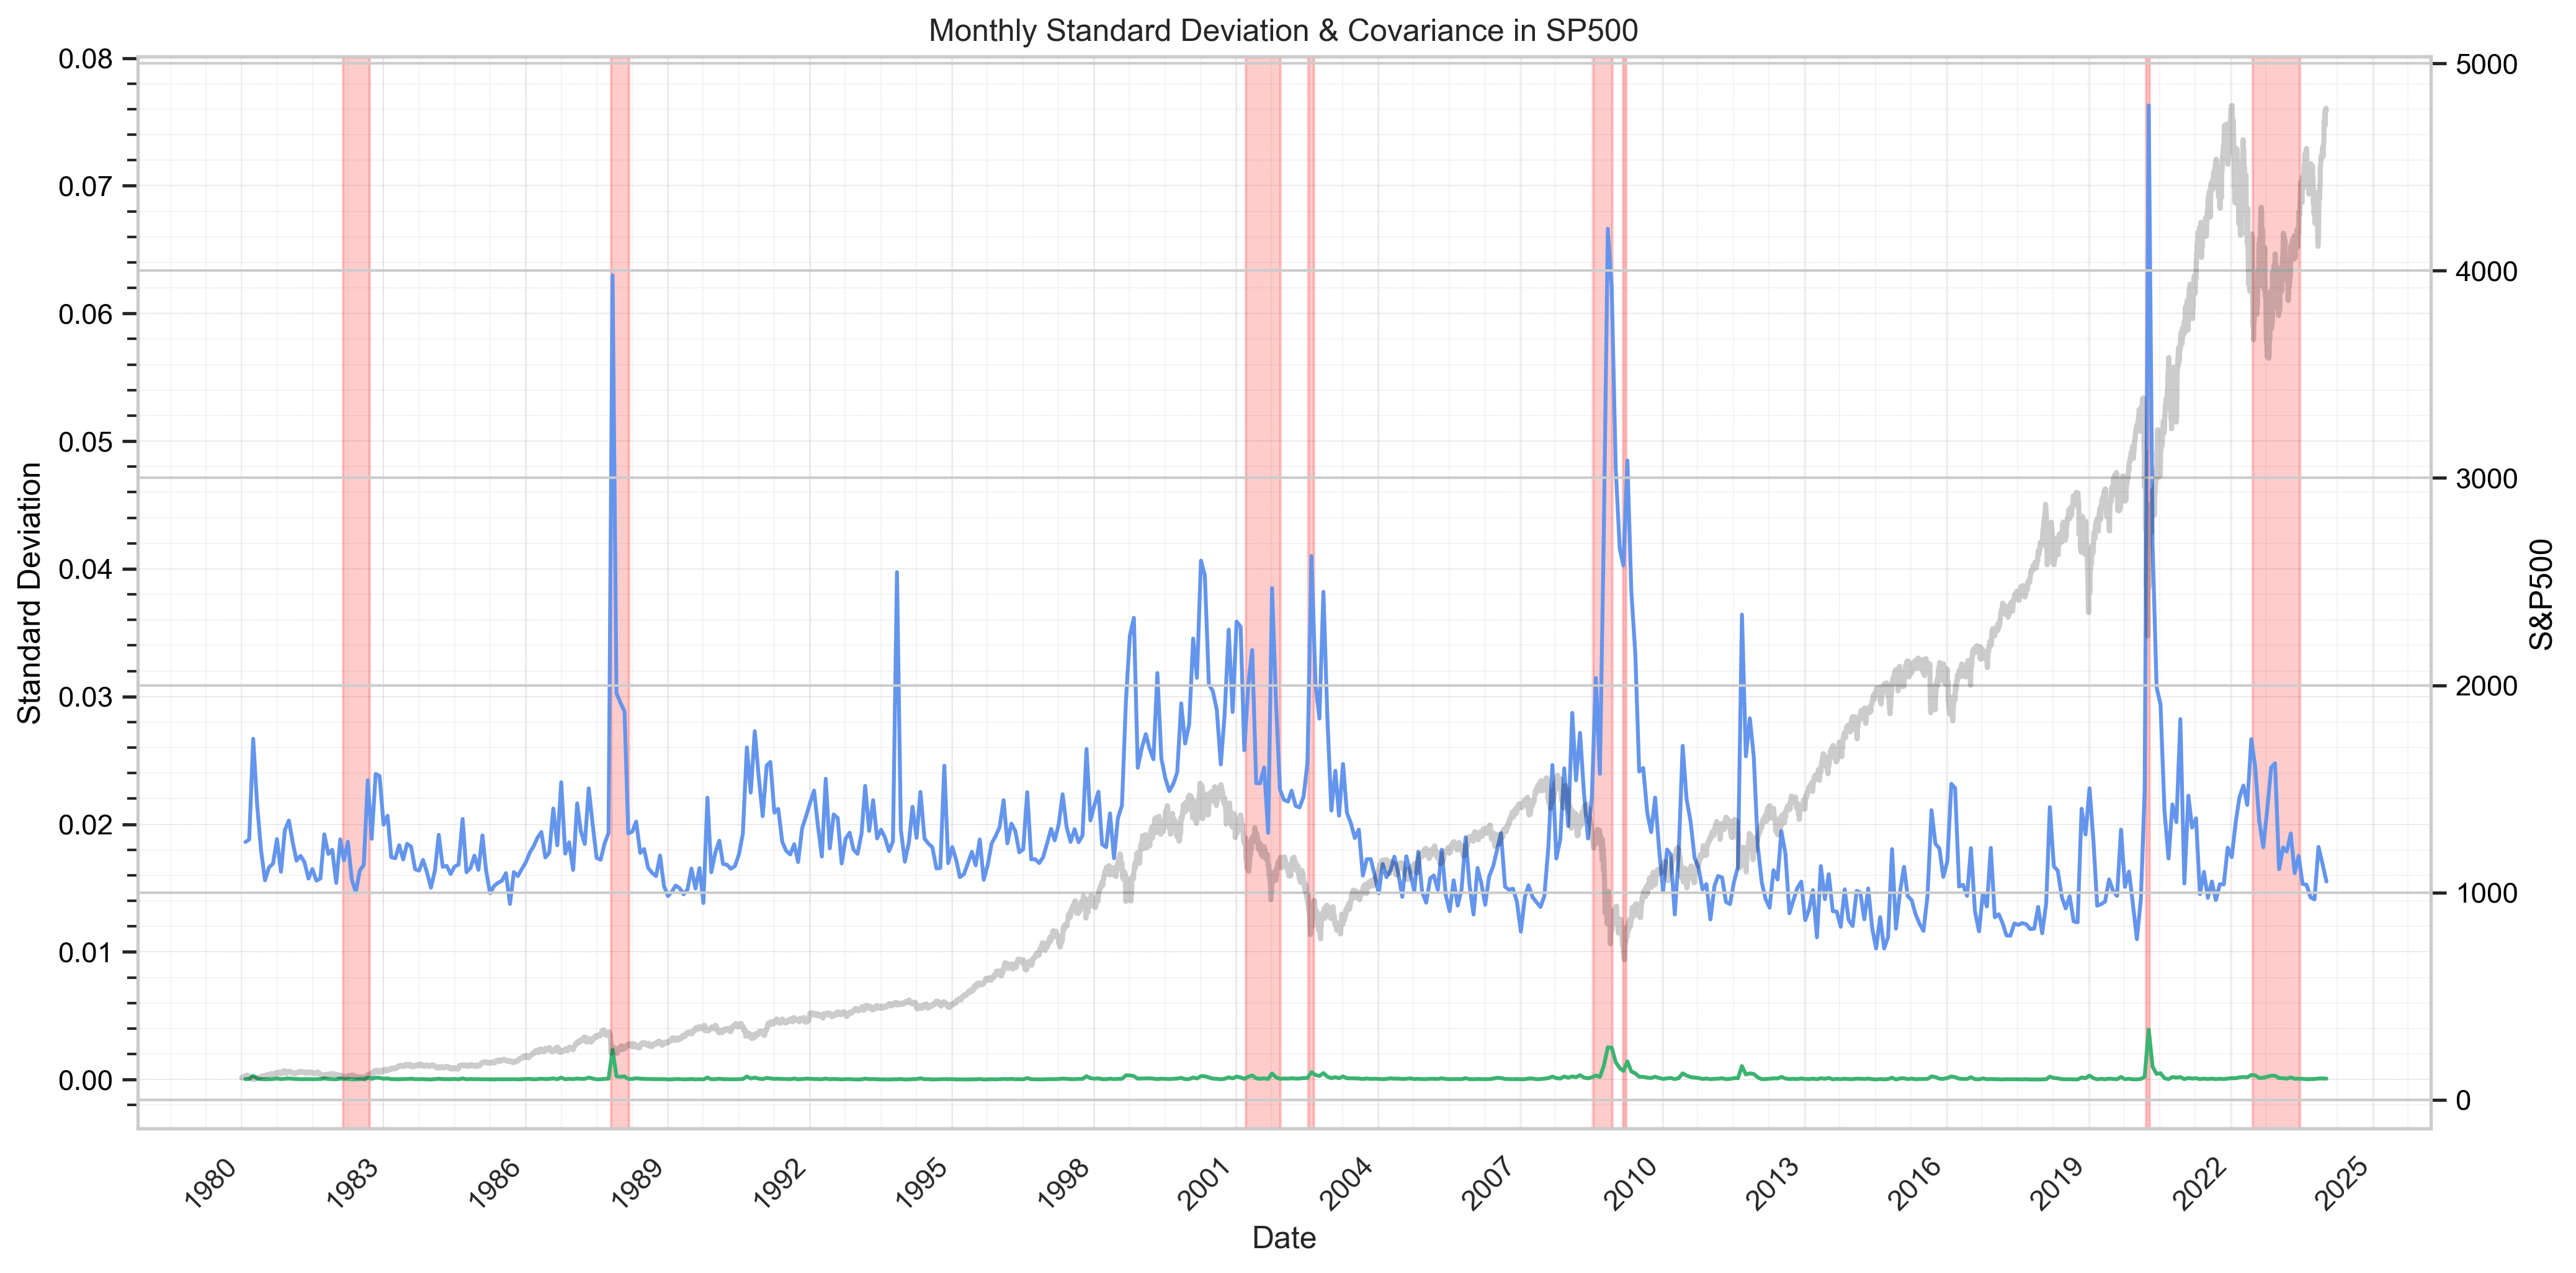

In [9]:
# Standard Deviation and Covariance
monthly_std = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(lambda x: x.std().mean())

monthly_covar = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(
    lambda x: x.cov().mask(np.triu(np.ones(x.cov().shape), k=0).astype(bool)).stack().mean())

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 300)

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Standard Deviation', color='black')
ax1.plot(monthly_std.index, monthly_std, color='cornflowerblue', linewidth=1.5)
ax1.plot(monthly_covar.index, monthly_covar, color='mediumseagreen', linewidth=1.5)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')
ax1.minorticks_on()

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2)
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

plt.title("Monthly Standard Deviation & Covariance in SP500")
plt.tight_layout()
plt.show()

## Rolling-20 Correlation analysis

In [10]:
new_sp500 = sp500.iloc[:, :-2]

In [11]:
# The cell below takes more than a minute to run. It's a bit like watching paint dry on a wall, but the wall is worth it.

moving_correlations = {}
window_days = 20

num_rows = len(new_sp500)

for start_idx in range(num_rows - window_days + 1):
    end_idx = start_idx + window_days
    window_data = new_sp500.iloc[start_idx:end_idx]
    
    calc_corr = window_data.corr()
    
    window_corr = calc_corr.mask(
        np.triu(np.ones(calc_corr.shape), k=0).astype(bool)
    ).stack().mean()
    window_end_date = window_data.index[-1]
    moving_correlations[window_end_date] = window_corr
moving_correlations_df = pd.DataFrame(list(moving_correlations.items()), columns=['Date', 'Average Correlation']).set_index('Date')

In [12]:
# Plotting
# fig, ax1 = plt.subplots(figsize=(14, 7), dpi=300)

# ax1.set_xlabel('Date')
# ax1.set_ylabel('Average Correlation', color='black')
# ax1.plot(moving_correlations_df.index, moving_correlations_df['Average Correlation'], color='cornflowerblue', linewidth=1.5)
# ax1.tick_params(axis='y', labelcolor='black')
# ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
# ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')
# ax1.minorticks_on()

# for start, end in crisis_periods:
#     ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.2)

# ax2 = ax1.twinx()  
# ax2.set_ylabel('S&P500', color='black')  
# ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.3)
# ax2.tick_params(axis='y', labelcolor='black')

# ax1.xaxis.set_major_locator(mdates.YearLocator(3))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# plt.title("Monthly Average Correlation")
# plt.tight_layout()
# plt.show()

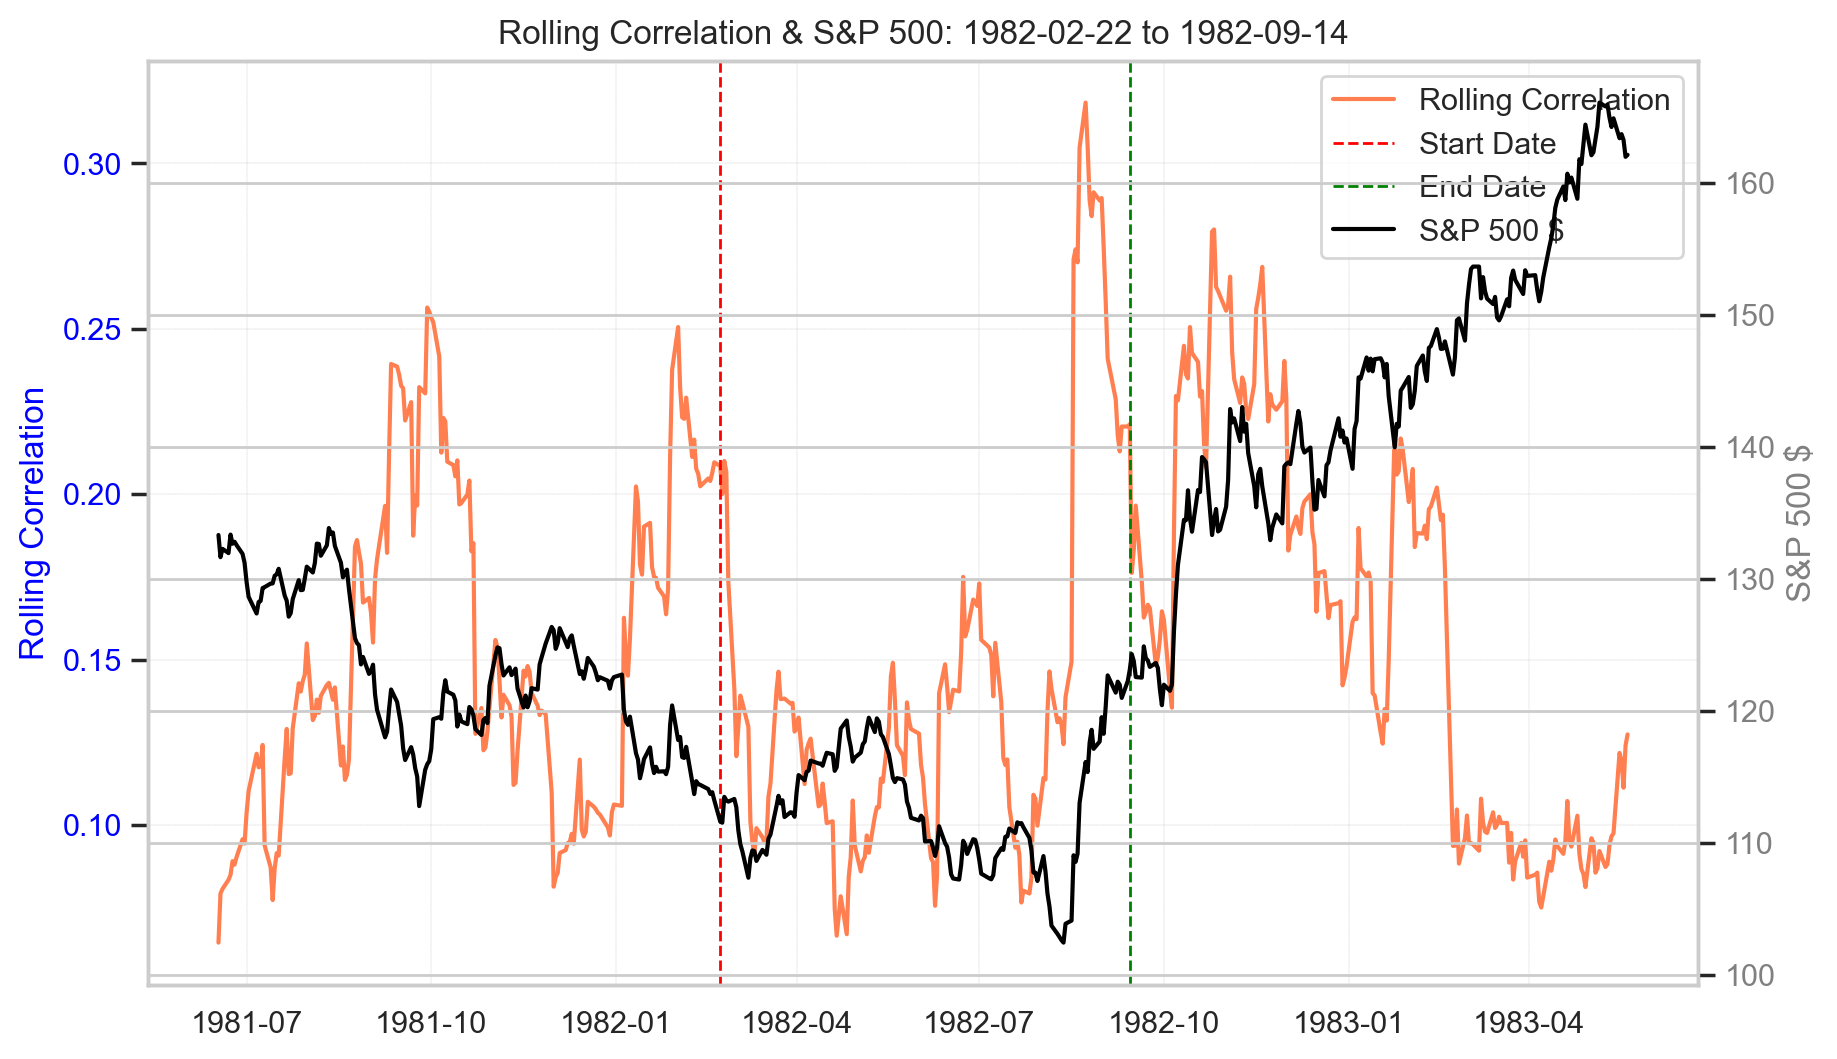

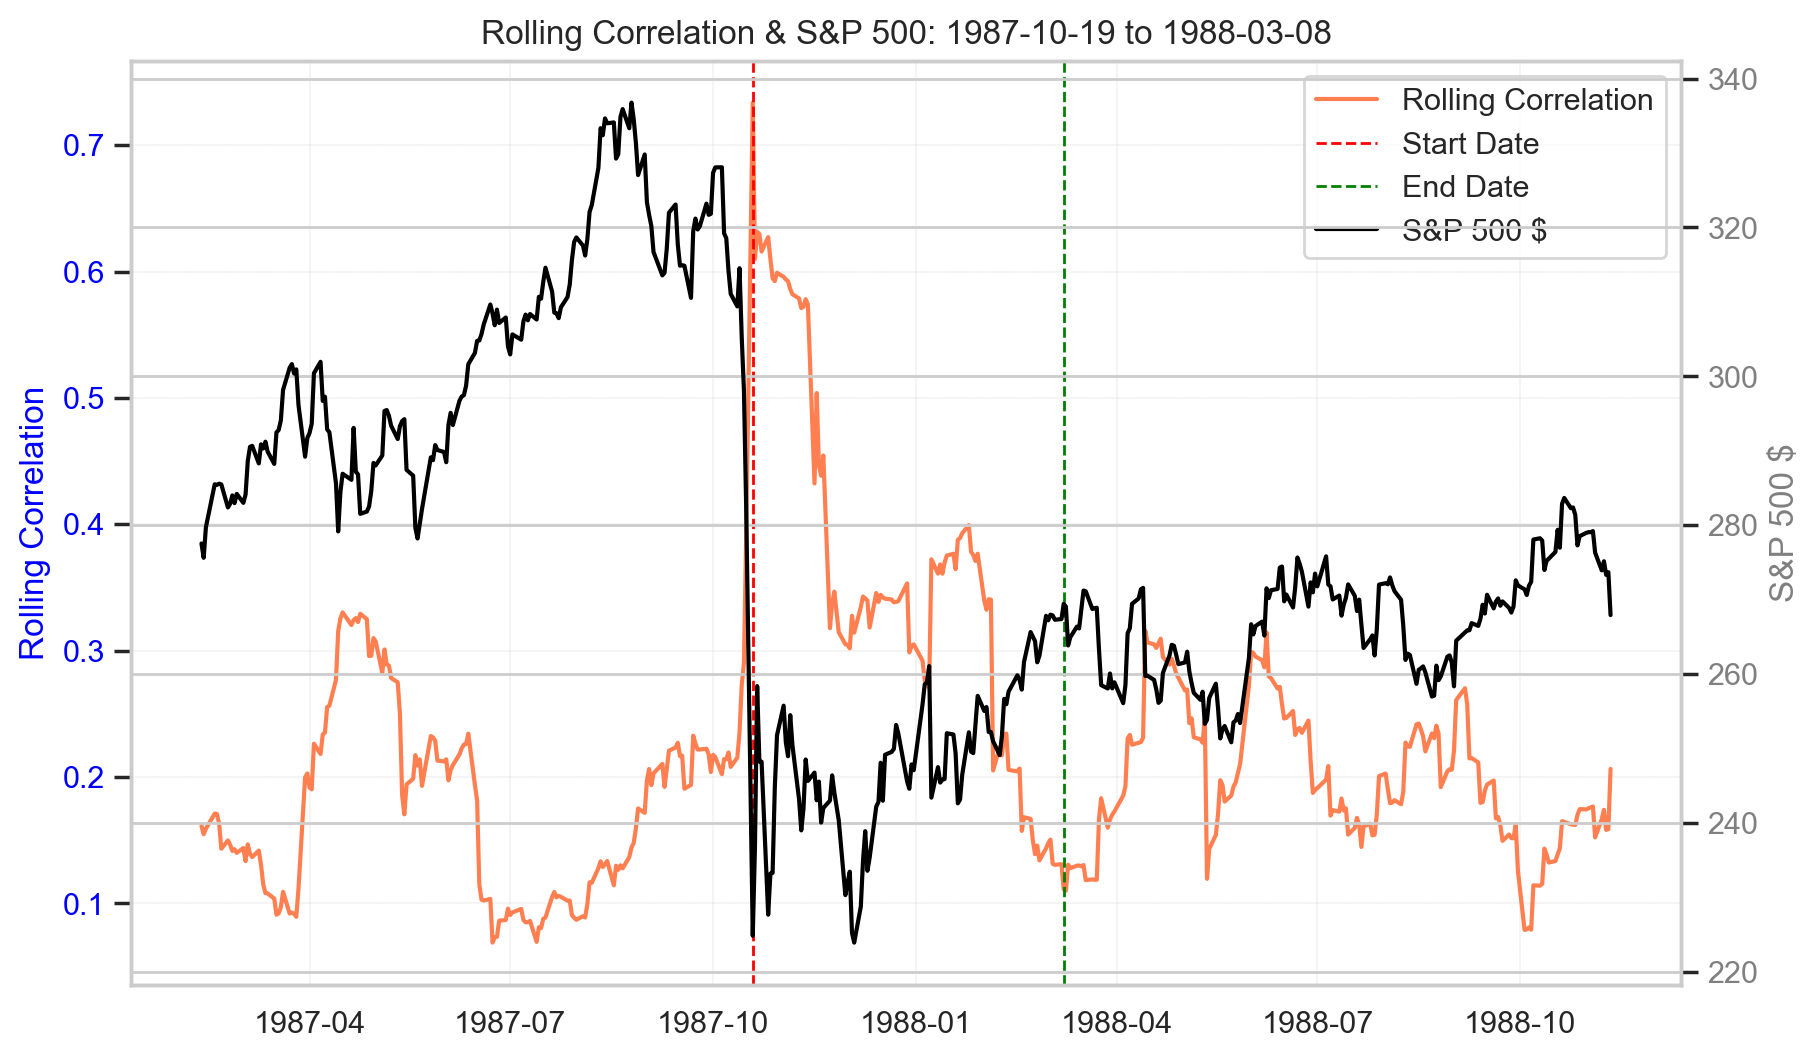

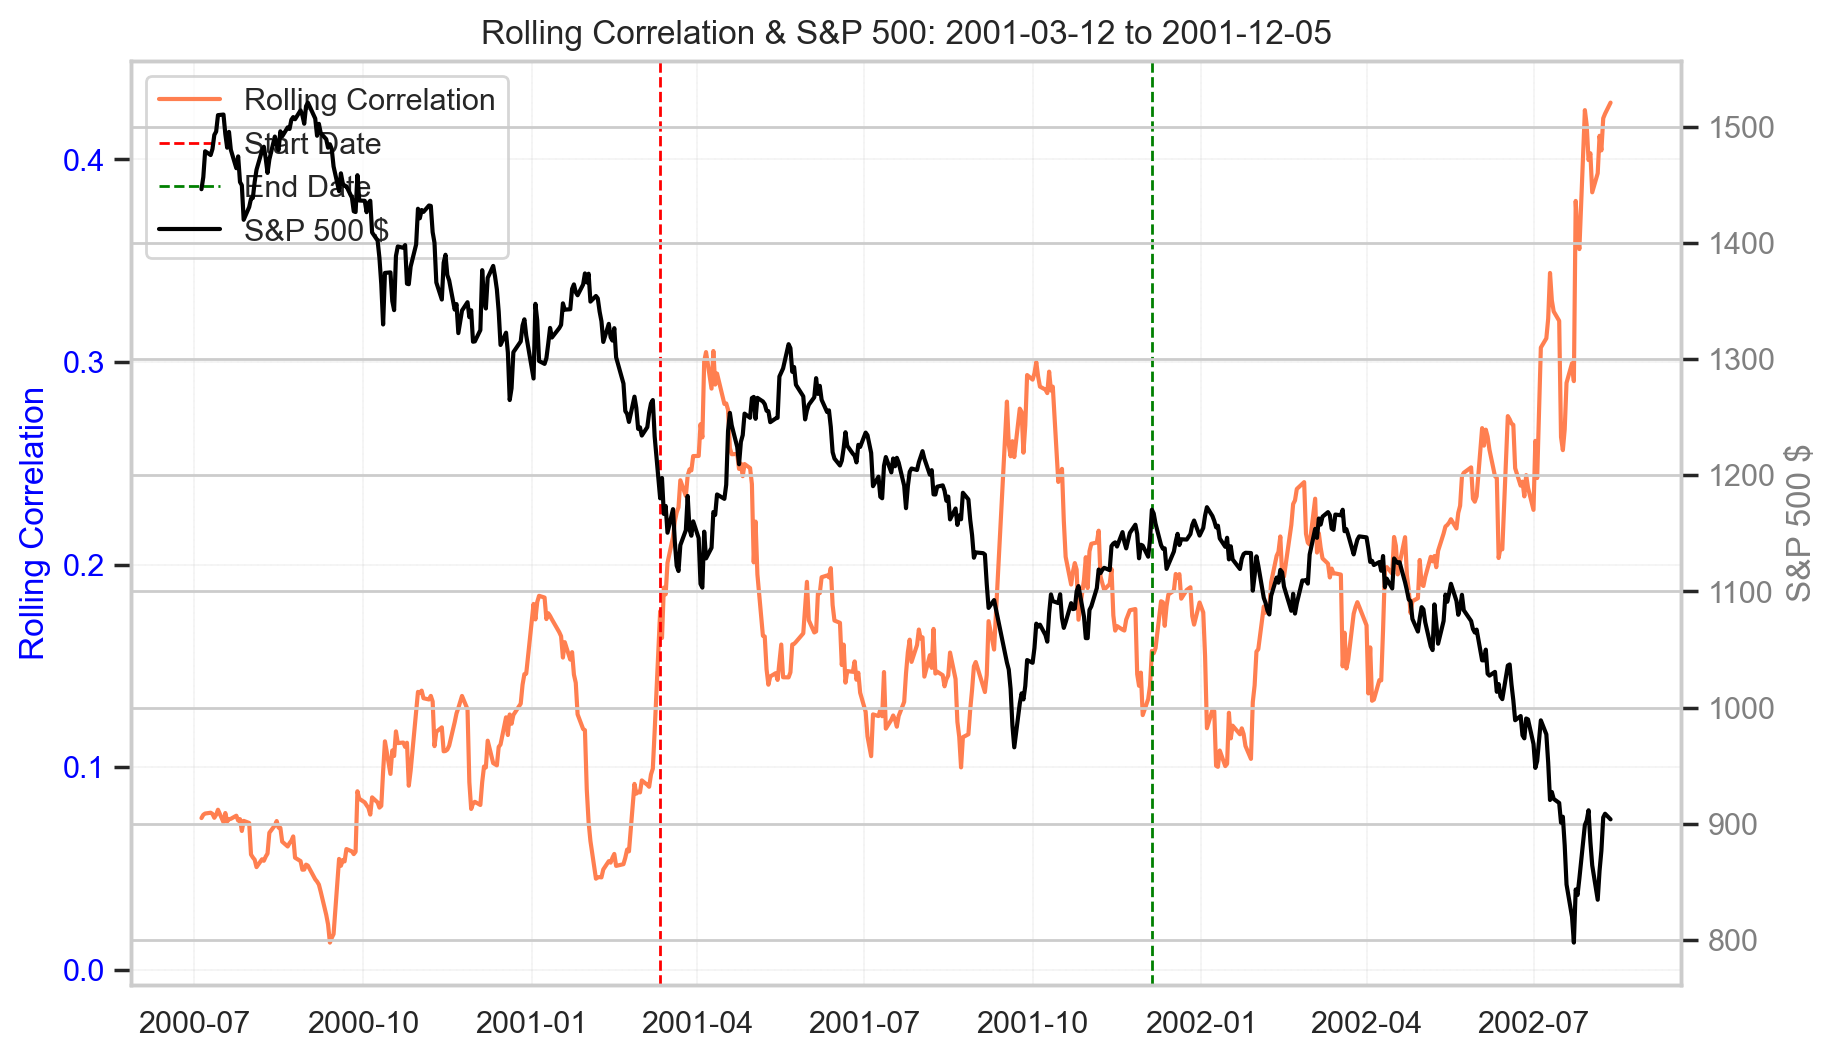

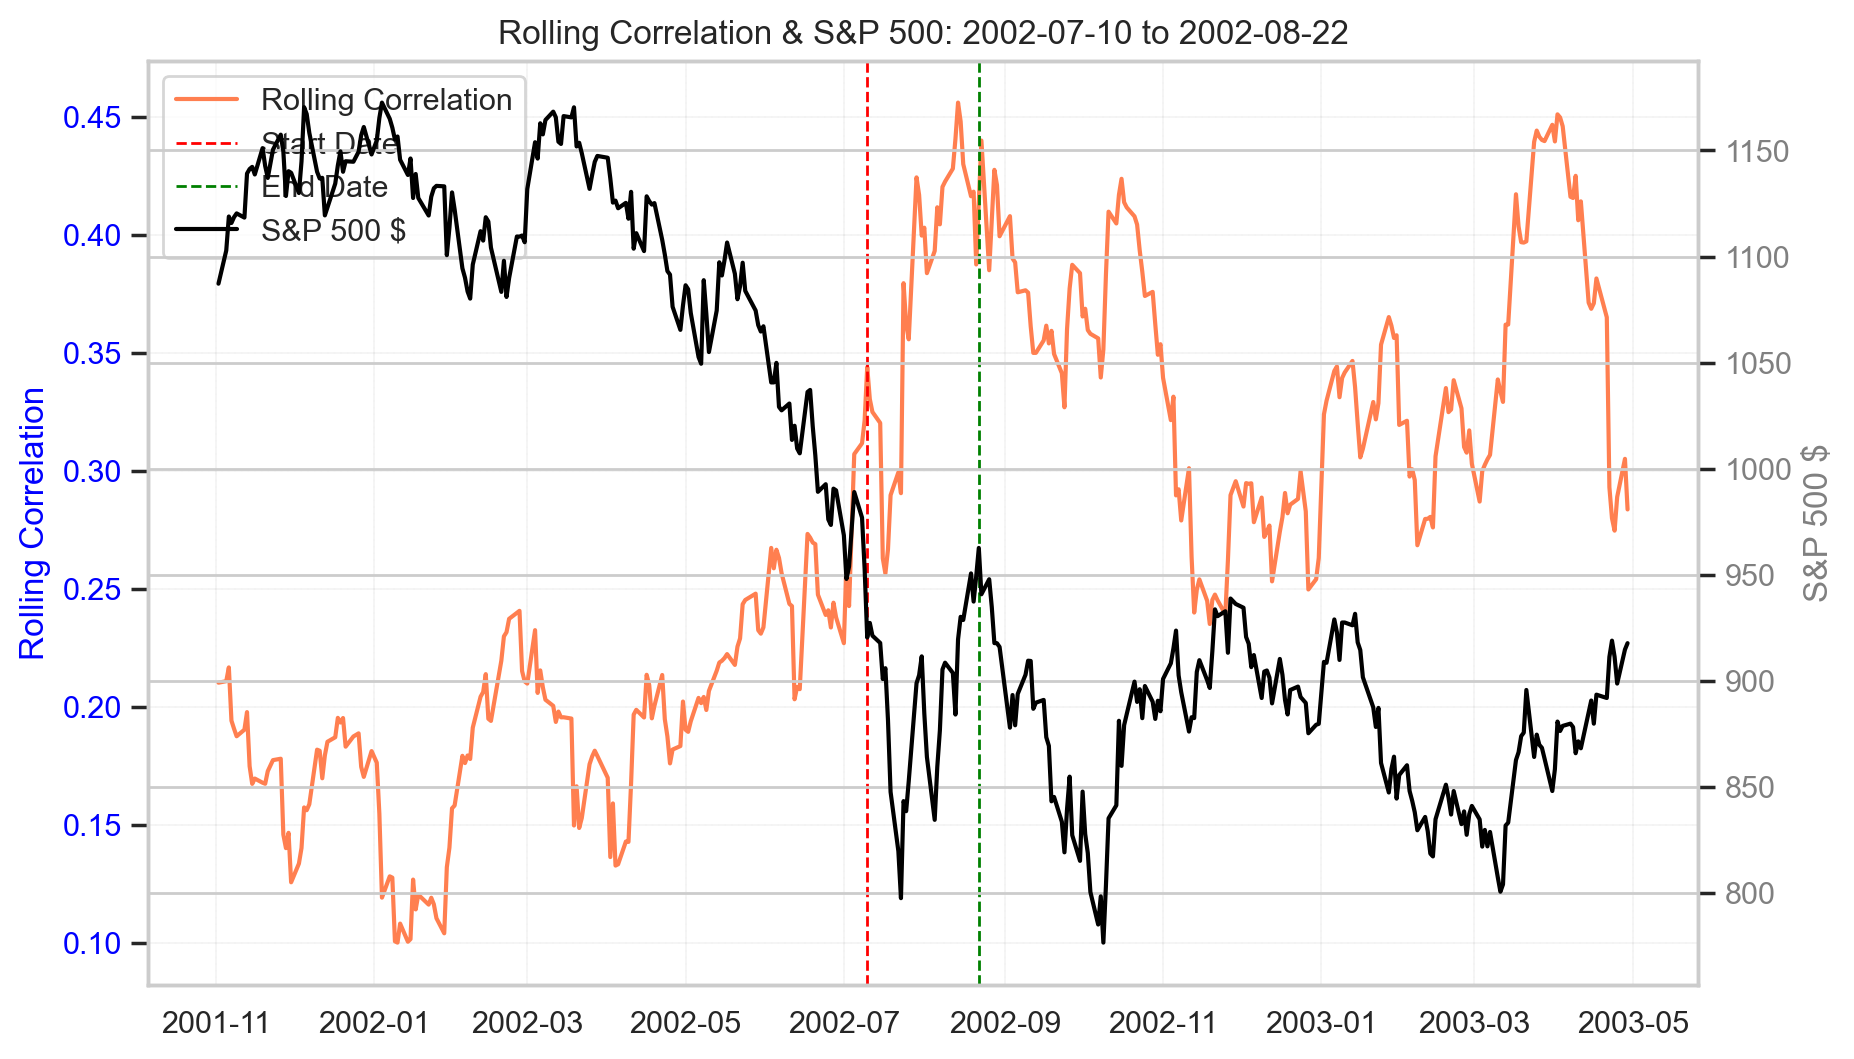

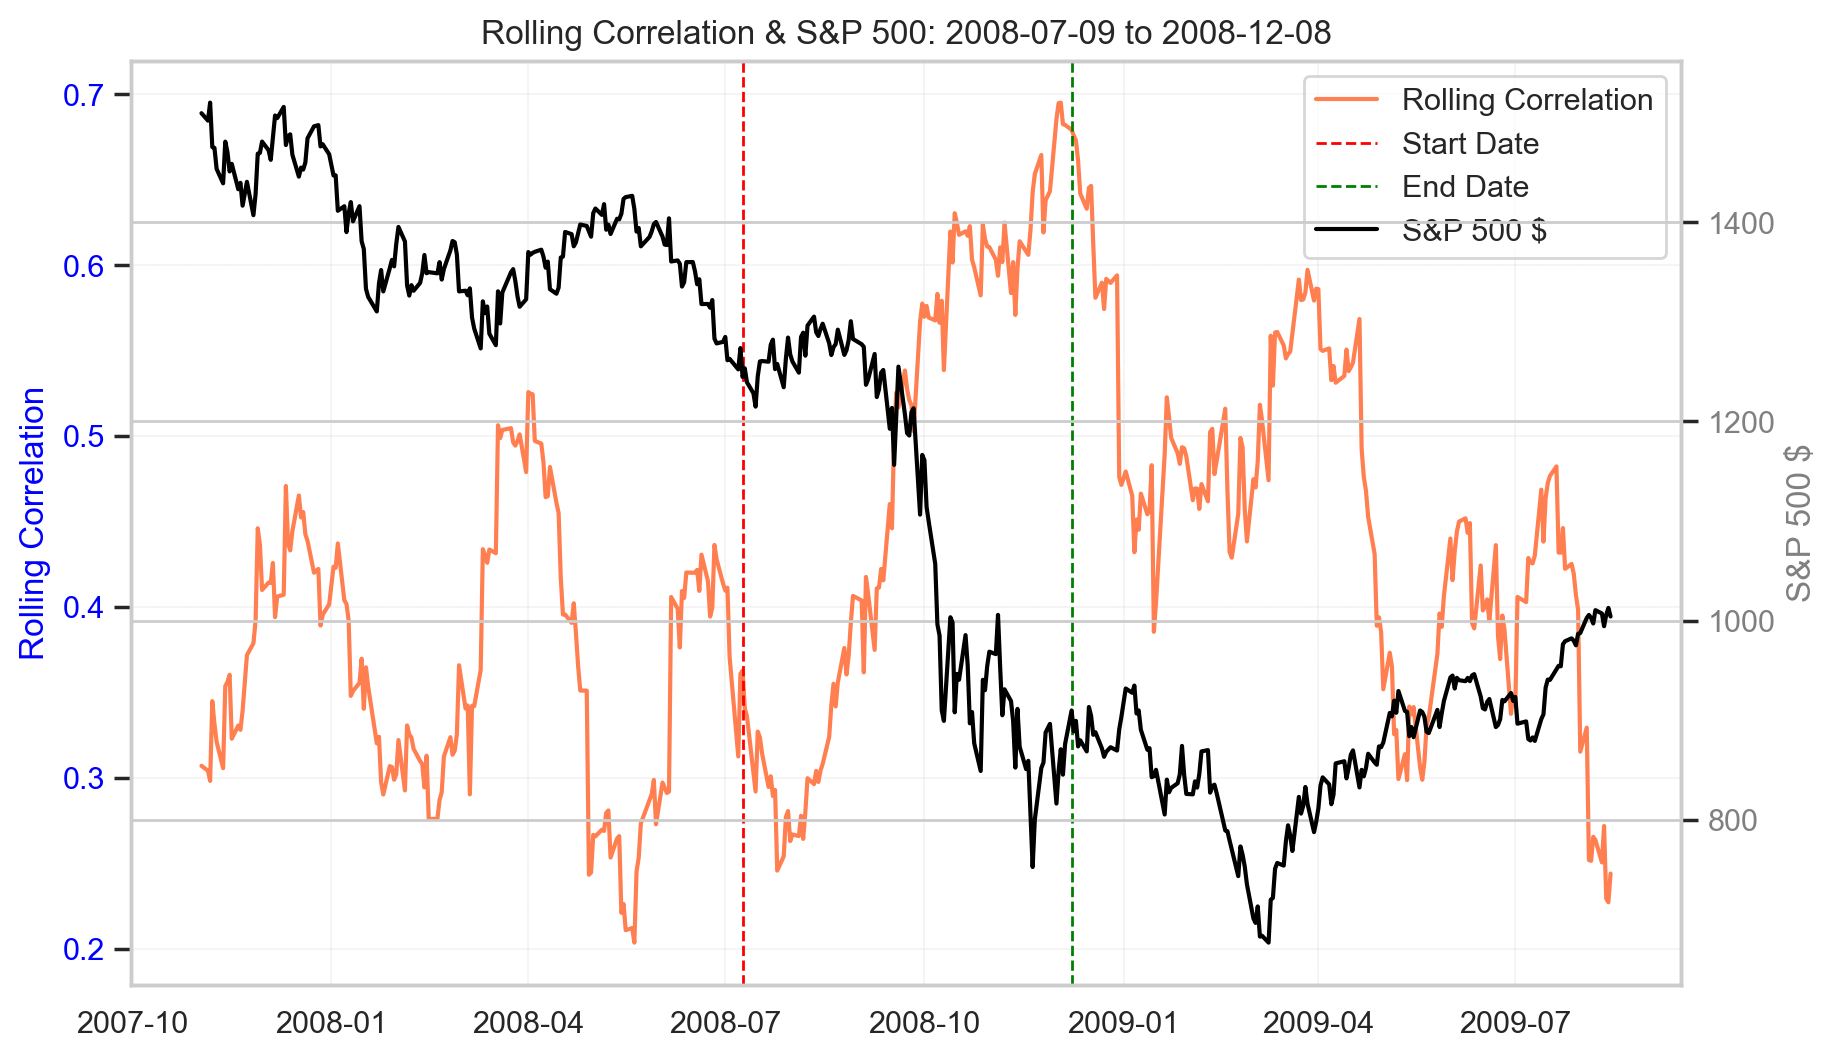

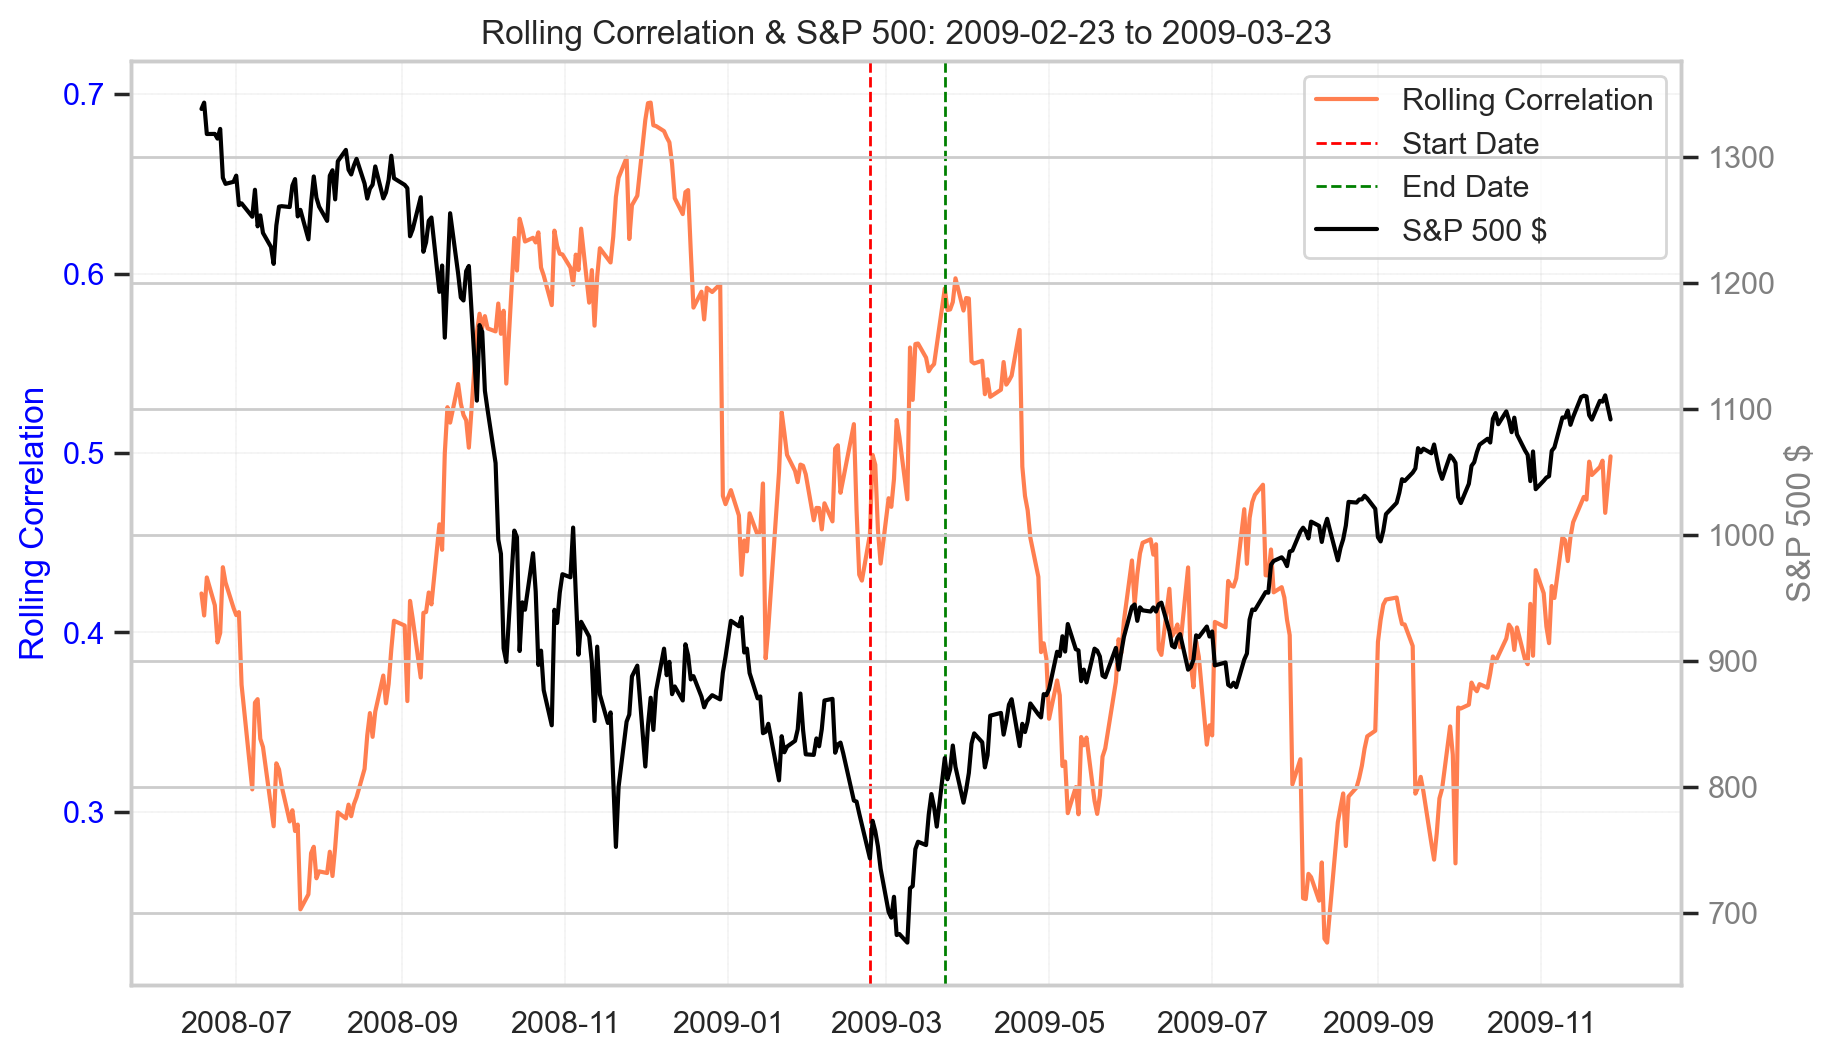

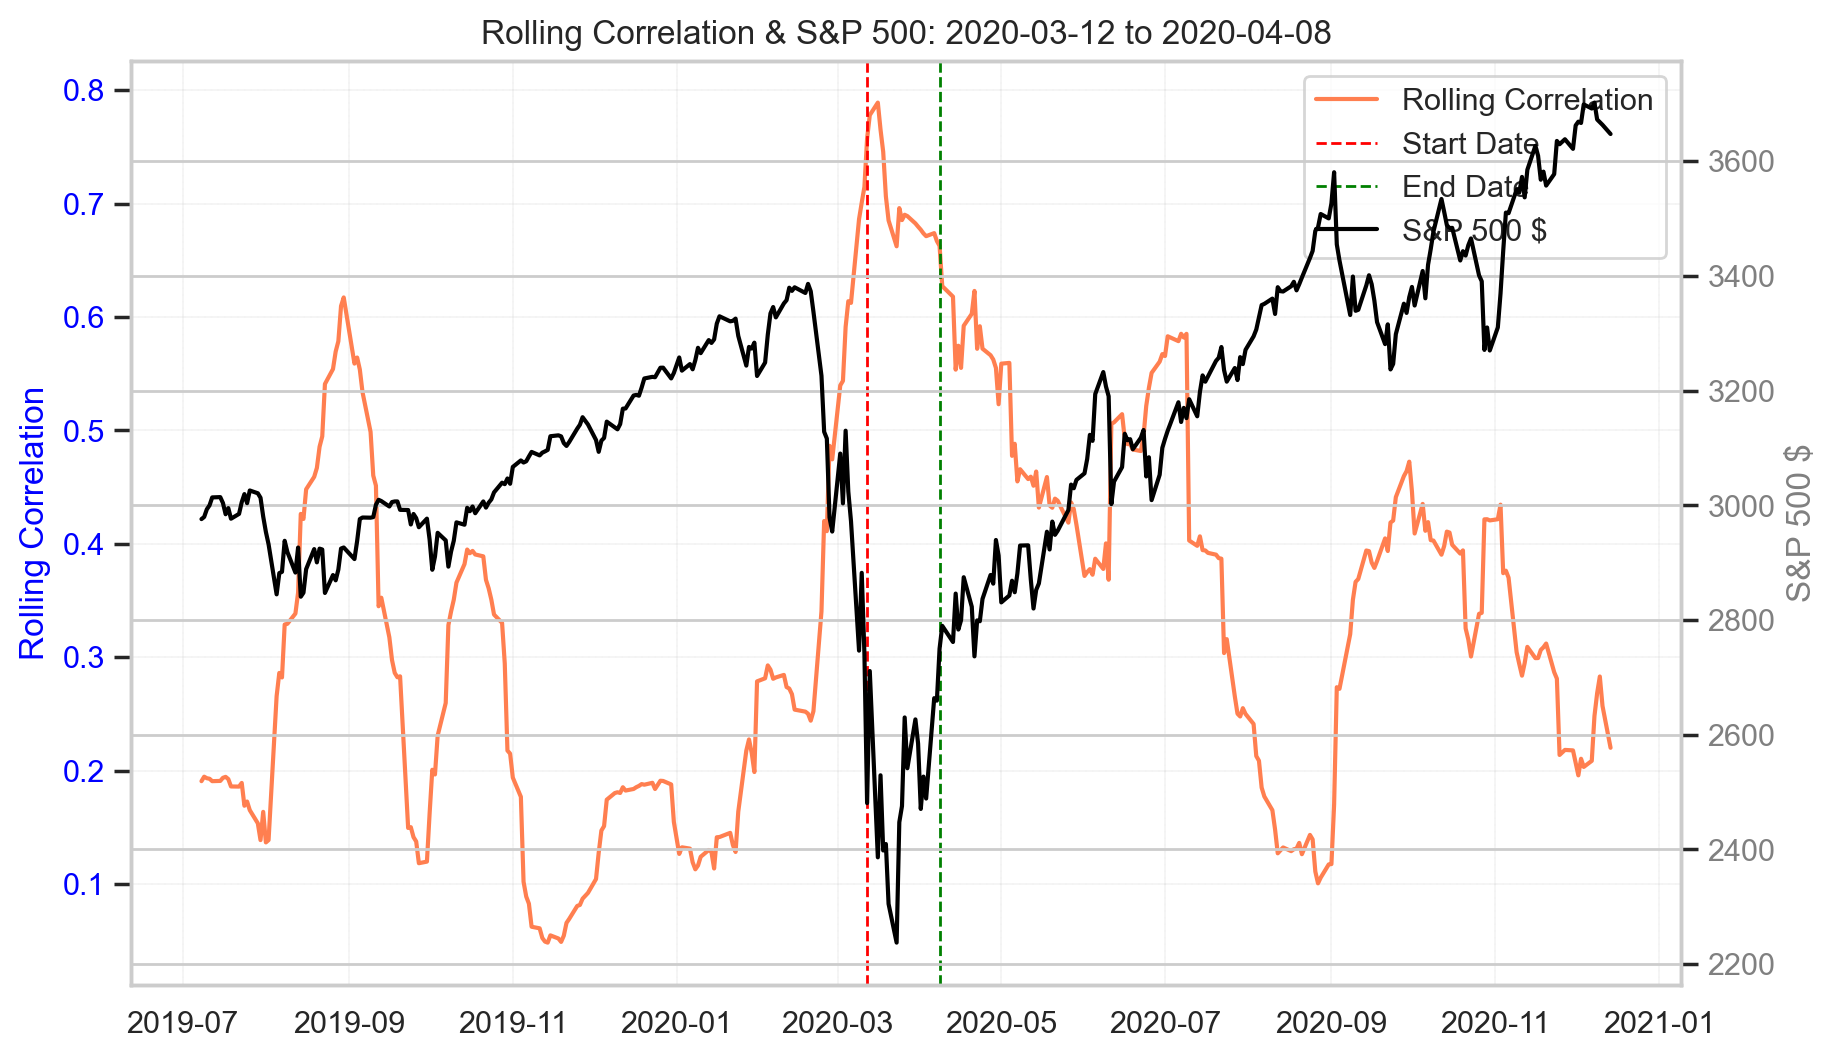

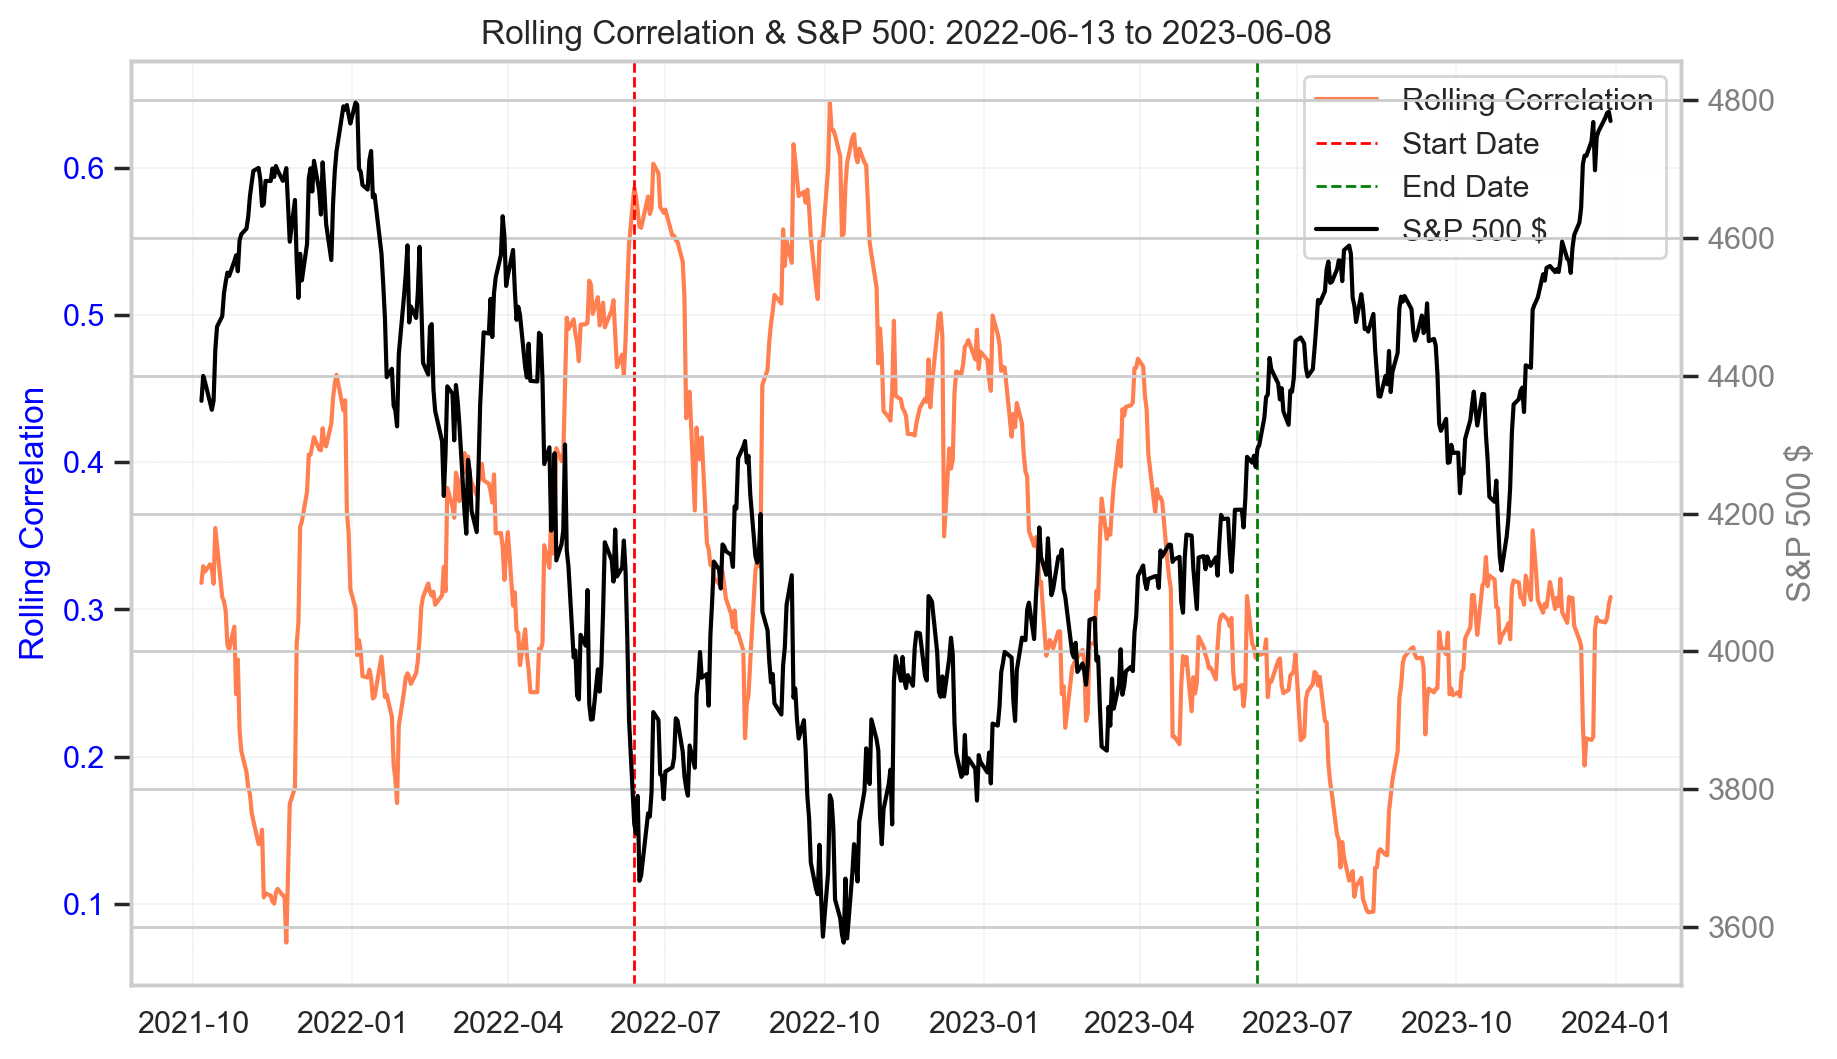

In [13]:
rolling20Correl = moving_correlations_df

for start_date, end_date in crisis_periods:
    adjusted_start_date = start_date - pd.Timedelta(days=250)
    adjusted_end_date = end_date + pd.Timedelta(days=250)
    
    fig, ax1 = plt.subplots(figsize=(10,6),dpi = 200)
    ax1.plot(rolling20Correl.loc[adjusted_start_date:adjusted_end_date], color='coral', label='Rolling Correlation', linewidth=1.5)
    
    ax1.axvline(x=start_date, color='red', linestyle='--', lw=1, label='Start Date', linewidth = 1.8)
    ax1.axvline(x=end_date, color='green', linestyle='--', lw=1, label='End Date', linewidth = 1.8)

    ax1.grid(True, which='major', linestyle='--', linewidth='0.08', color='grey')
    ax1.grid(True, which='minor', linestyle='--', linewidth='0.08', color='grey')
    
    ax2 = ax1.twinx()  
    ax2.plot(sp500['^GSPC'].loc[adjusted_start_date:adjusted_end_date], color='black', alpha=1, label='S&P 500 $', linewidth=1.5)

    ax1.set_title(f"Rolling Correlation & S&P 500: {start_date.date()} to {end_date.date()}")
    ax1.set_ylabel('Rolling Correlation', color='blue')
    ax2.set_ylabel('S&P 500 $', color='gray')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='gray')
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='best')
    plt.show()

## Rolling correlations
1. To reduce the noise and analyze the periods carefully, each crisis gets its own plot with rolling correlation (to make the line smoother) and SP500 returns. The relationship should be inverse during the crisis indicating sell-off in market leading to lower returns and higher correlation.
2. We urge the reader to obeserve a little before the start of crises (to account for our definition of crisis of -20% return) till a little after the end.

* Crisis of 1982 - Recession and high inflation
    + We do observe a hint of inverse relation but partial data (only 196 stocks) do not reflect it completely.
* Crisis of 1987 - Black Monday
    + As we get more data we start to notice the trend of sell-off throughout market with correlations reaching to just above 0.7.
    + There is no concrete origin of the black monday but a running theory is of algo trading's snowball effect.
* Crisis of 2001 - Dot-com and terrorist attack
    + Dot-com bubble was slowing down and many companies declared bankruptcy leading to -20% return.
    + Terrorist attack in USA in September led to even more downturn where the panic in market is apparent in an evident inverse effect of high correlation and negative returns.
* Crisis of 2002 - Dot-com
    + Capital for internet companies dried up and higher than before bankruptcies led to investors with empty hands and high correlation of negative sentiment.
* Crisis of 2008 - The great financial crisis
    + Decline in home sales, foreclosures, toxic bank debts, Fannie Mae's and Freddie Mac's shares tumble trigger our crisis with -20% returns.
    + With bankruptcy declaration of Bear Sterns on September 15, market panic shows very high correlation and very negative returns showcasing a good example of a cross pattern
* Crisis of 2009 - After effects of the GFC
    + Due to our definition of a crisis we get another crisis in 2009 but for a period of just a month.
    + Government announced stimulus package leading to +20% return from the lowest point but the problem was deep. Government had to announce a lot of "bailouts" leading to worse outlooks for the economy.  
* Crisis of 2020 - Global pandemic
    + WHO recommeded the outbreak of Covid-19 virus with quarantine measures. Leading the market to forecast reduced demands globally and a sell-off.
    + Global reduced demand leads to a higher correlation across the industries mitigated by stimulus package announcement by the fed.
* Crisis of 2022 - Interest rate hikes
    + This 'crisis' lasts for a year with correlation and negative returns having an inverse relationship multiple times.
    + After the crisis we see correlation dropping but returns increasing. We will touch upon it later but essentially bearish market makes people react more compared to bull market.
    + For this crisis, the returns were lead by 'the magnificent seven' (seven stocks) hence lower average correlation among all stocks.

{{< pagebreak >}}
## Correlation might be limited
1. It only tells us if two things generally move in the same direction.
2. It doesn't consider **how much** they move compared to each other.
3. Another measure called Beta does this better.
4. Beta looks at both direction and how much one thing moves compared to the other.
5. Beta can give us a clearer picture when comparing how two stocks perform.





## Beta Analysis

## Monthly Beta analysis with summary statistics

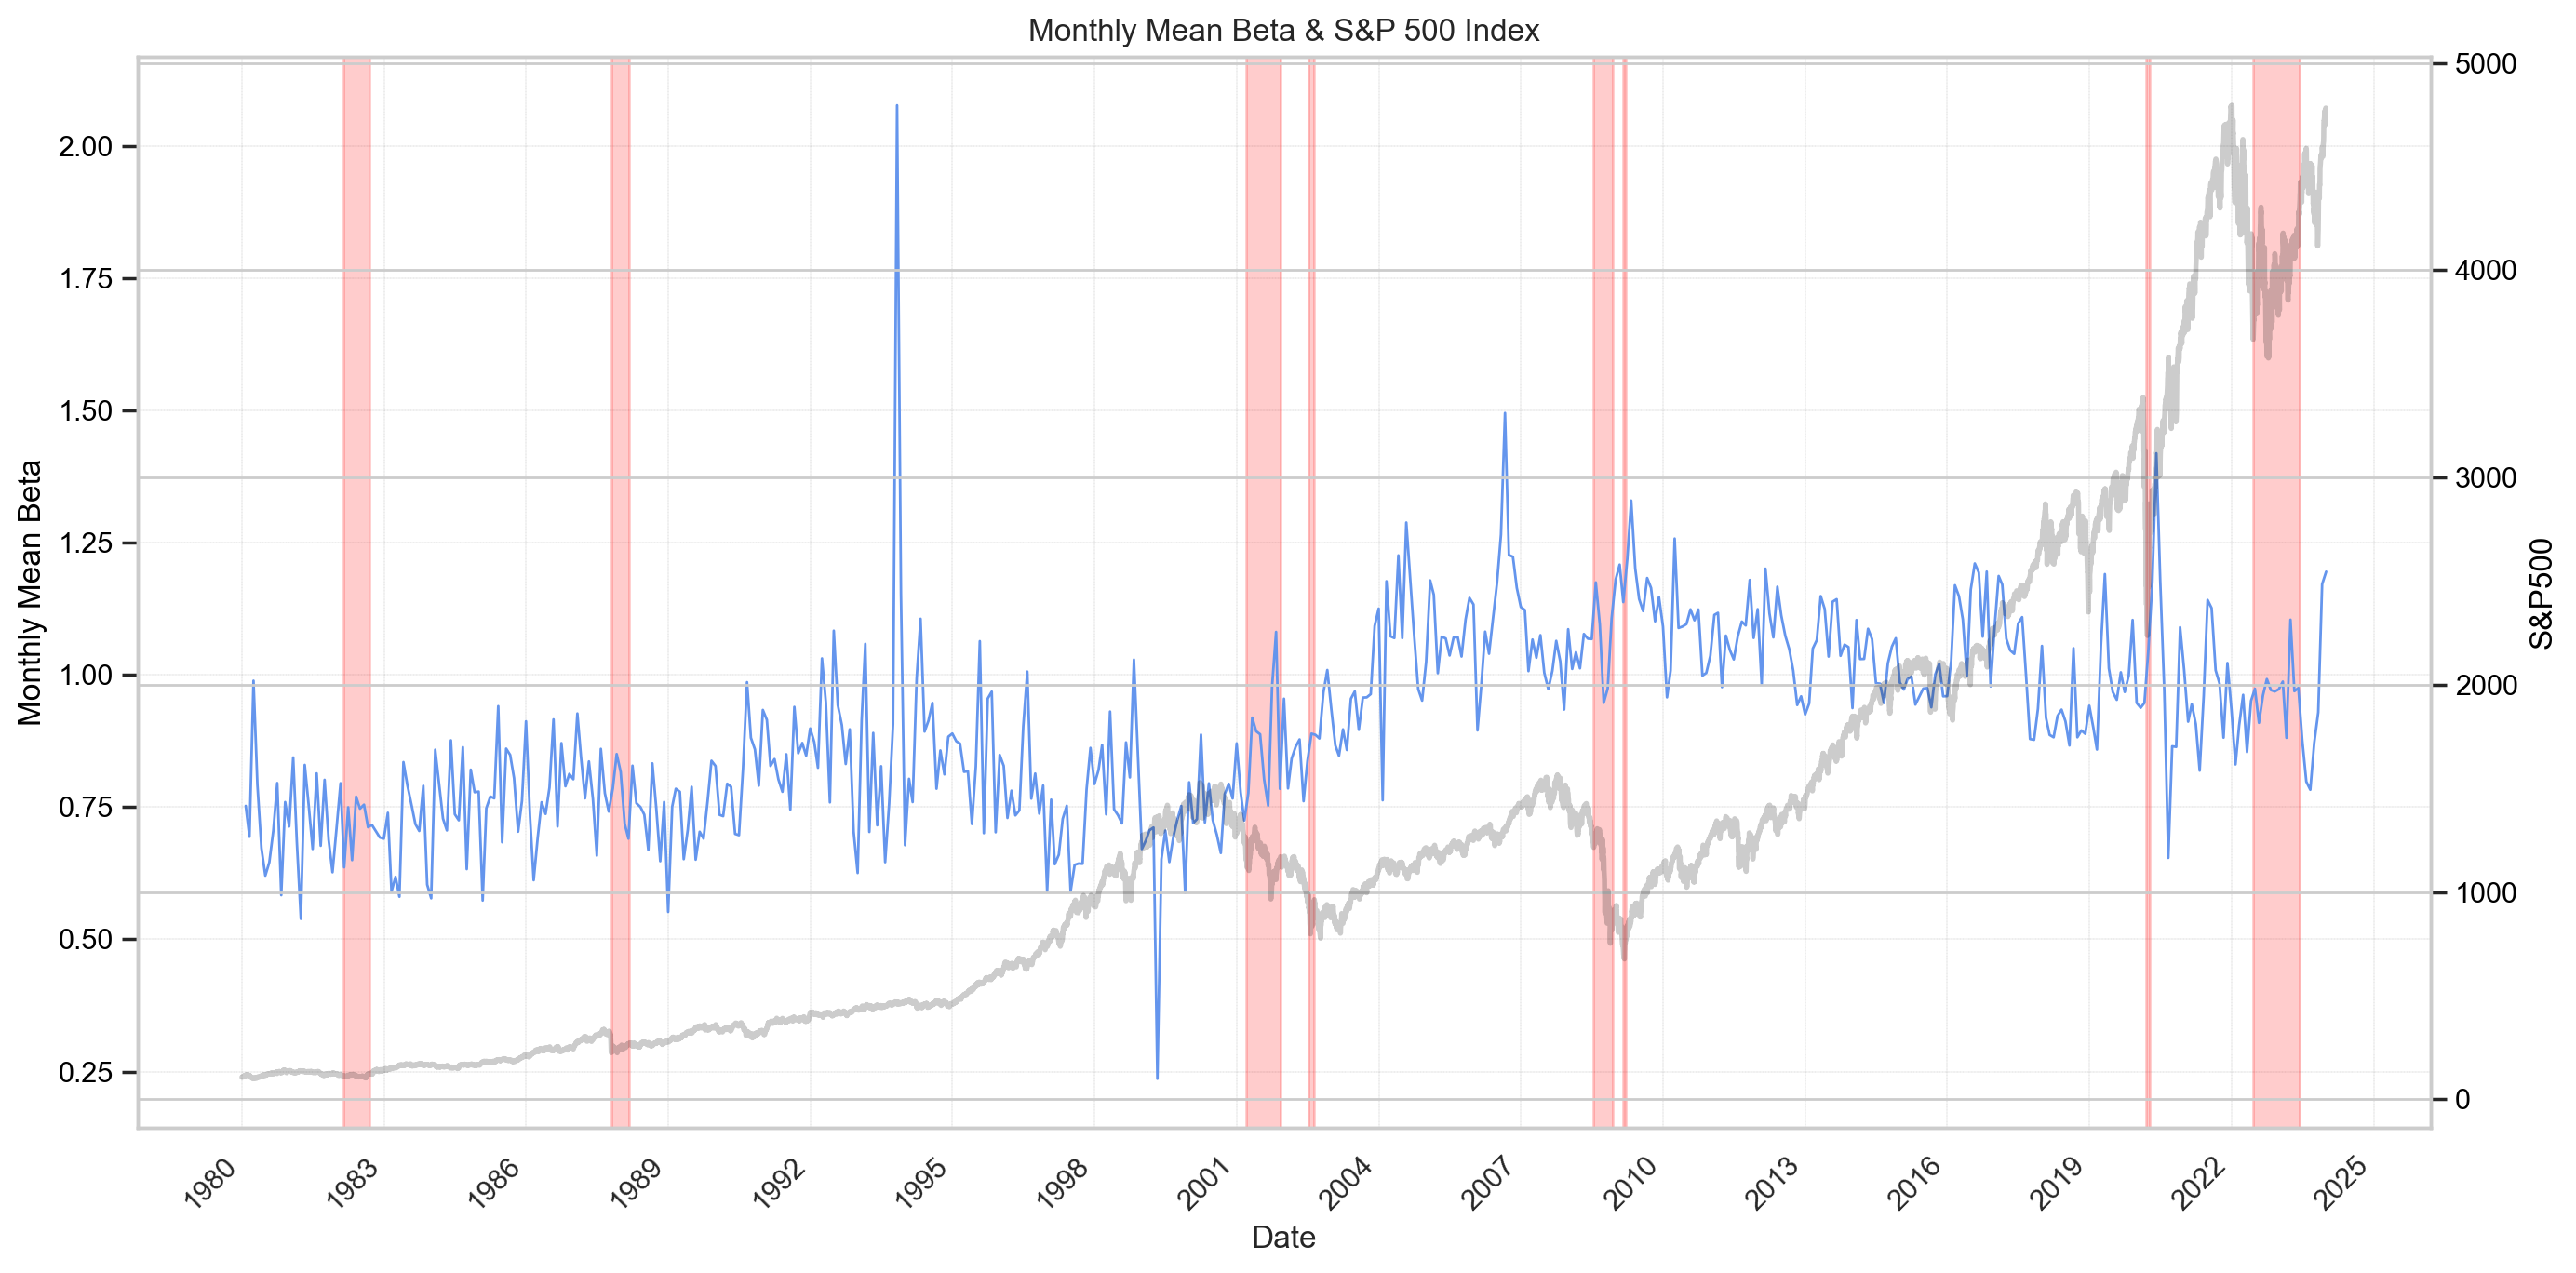

In [14]:
#MEAN
monthly_var_sp500 = sp500['sp500_dr'].resample('M').var()
monthly_cov_with_sp500 = sp500.iloc[:,:-2].resample('M').apply(lambda x: x.cov(sp500['sp500_dr']))
monthly_beta_mean = monthly_cov_with_sp500.div(monthly_var_sp500, axis=0).mean(axis=1)

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Mean Beta', color='black')
ax1.plot(monthly_beta_mean.index, monthly_beta_mean, color='cornflowerblue', linewidth=1)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2)
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

plt.title("Monthly Mean Beta & S&P 500 Index")
plt.tight_layout()
plt.show()

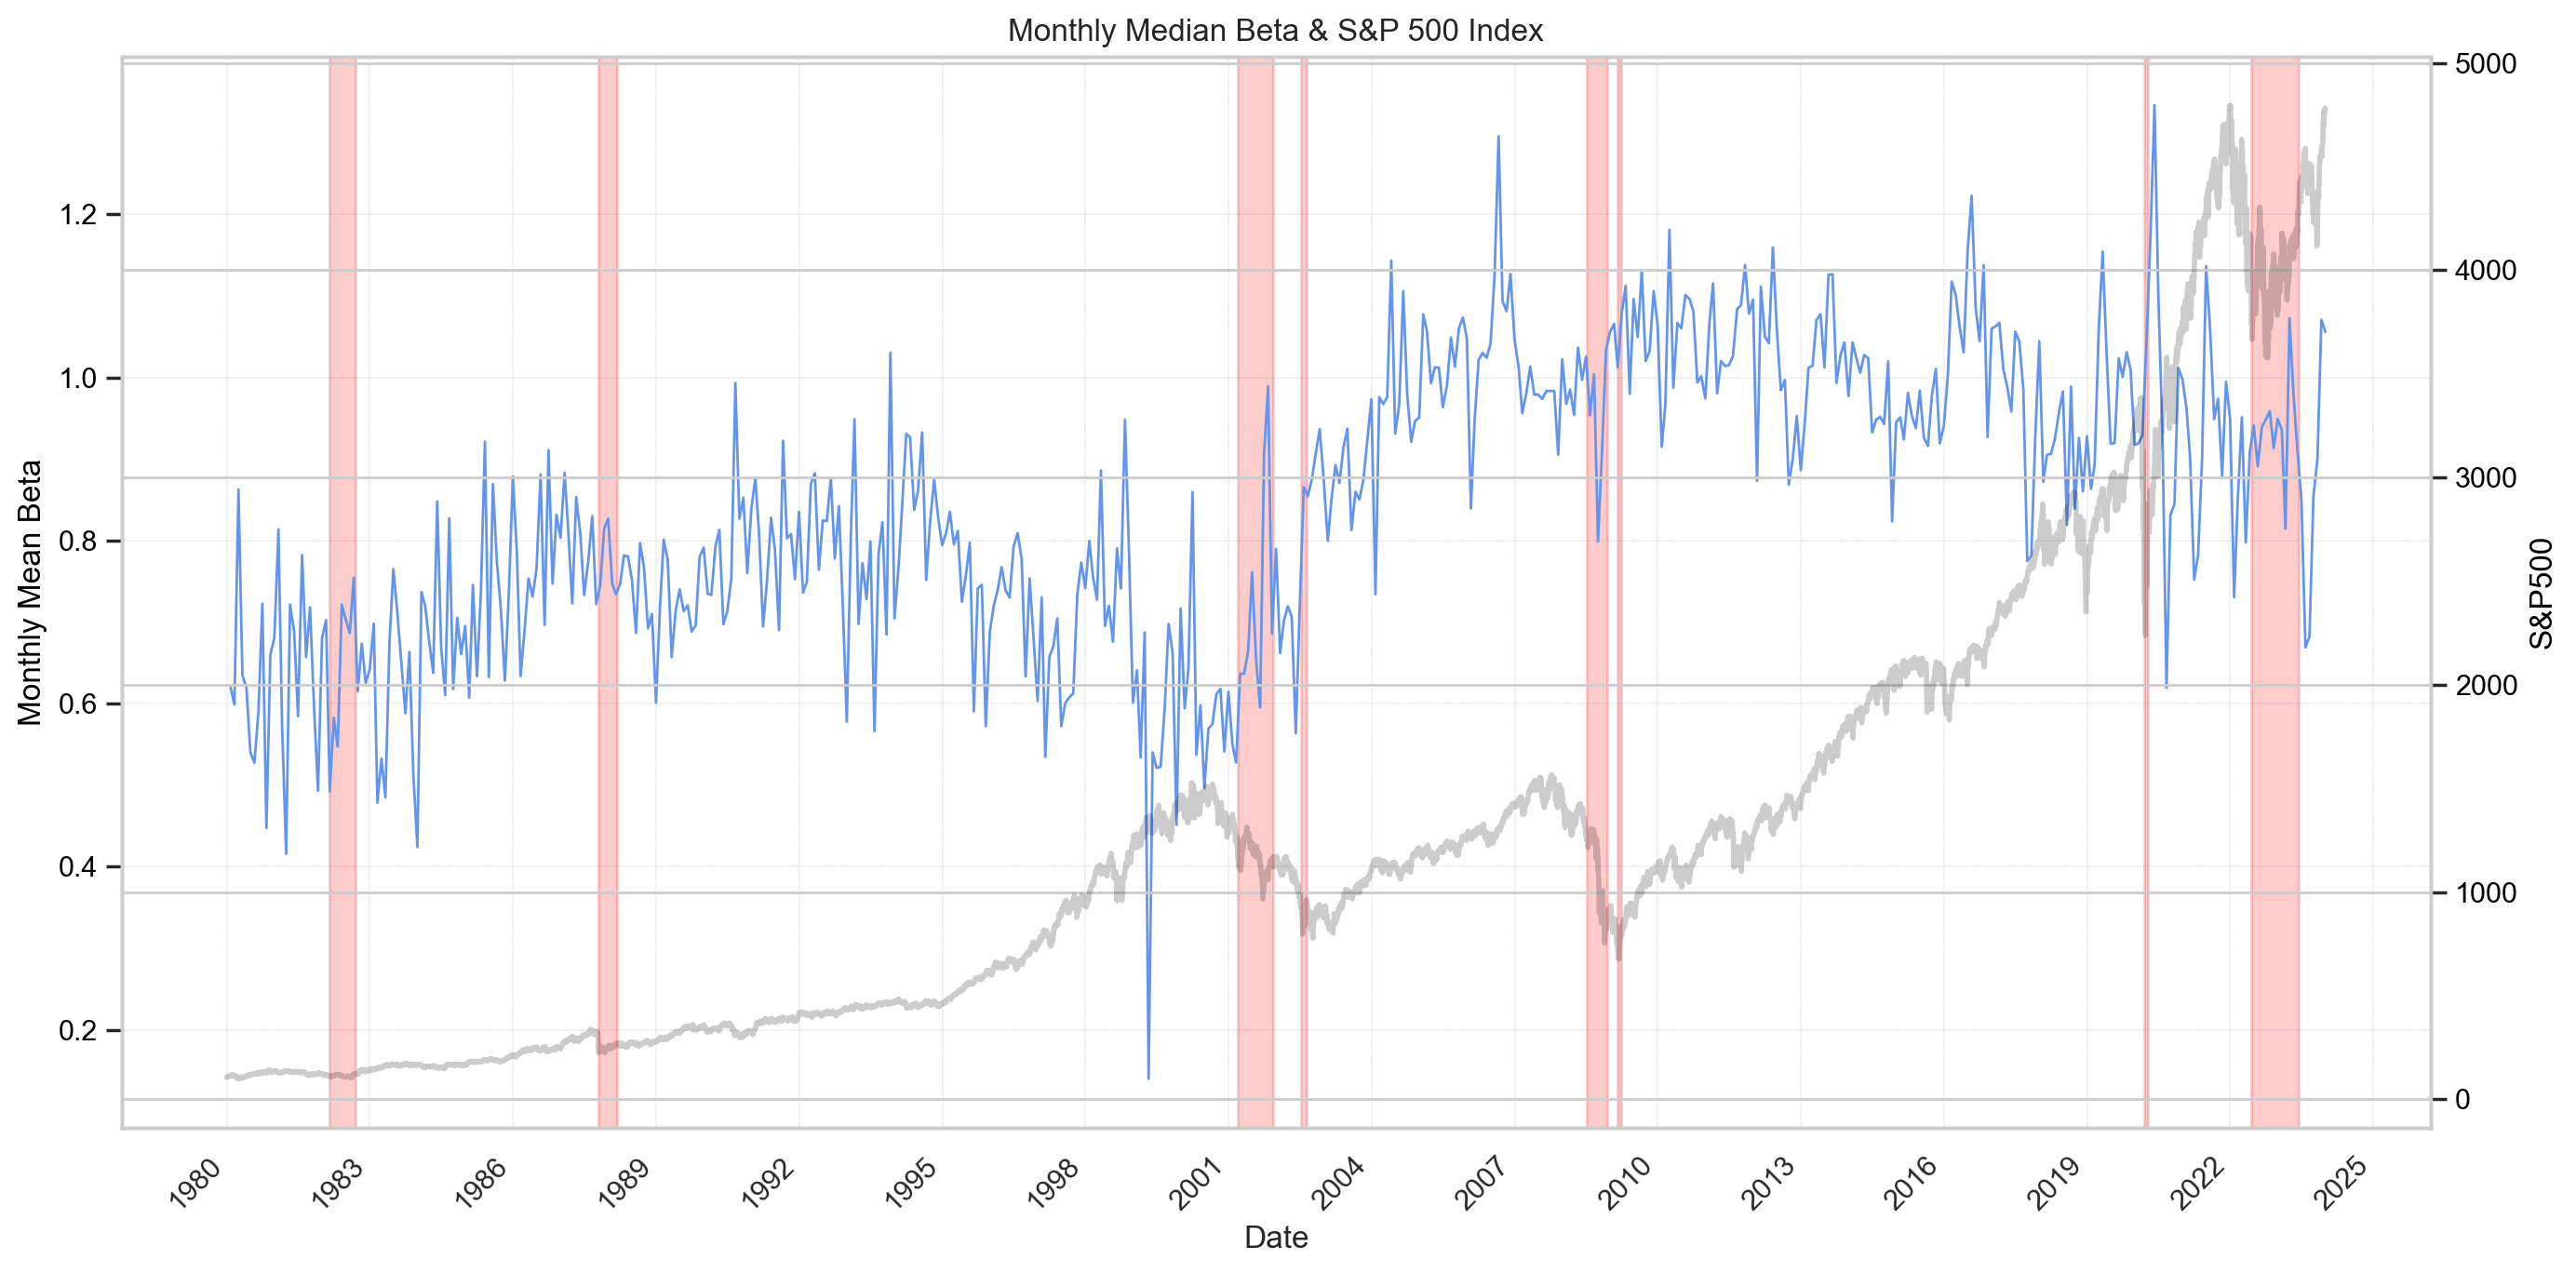

In [15]:
#MEDIAN
monthly_var_sp500 = sp500['sp500_dr'].resample('M').var()
monthly_cov_with_sp500 = sp500.iloc[:,:-2].resample('M').apply(lambda x: x.cov(sp500['sp500_dr']))
monthly_beta_median = monthly_cov_with_sp500.div(monthly_var_sp500, axis=0).median(axis=1)

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Mean Beta', color='black')
ax1.plot(monthly_beta_median.index, monthly_beta_median, color='cornflowerblue', linewidth=1)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2)
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

plt.title("Monthly Median Beta & S&P 500 Index")
plt.tight_layout()
plt.show()

In [16]:
results = []

for start_date, end_date in crisis_periods:

    beta_values = sp500.iloc[:, :-2].loc[start_date:end_date].apply(
        lambda x: x.cov(sp500['sp500_dr'].loc[start_date:end_date]) / sp500['sp500_dr'].loc[start_date:end_date].var()
    ).dropna()
    
    betas_in_range = beta_values[(beta_values >= 0.8) & (beta_values <= 1.2)]
    
    percent_in_range = len(betas_in_range) / len(beta_values) * 100
    beta_mean = beta_values.mean()
    
    results.append({
        "Start Date": start_date,
        "End Date": end_date,
        "% in range 0.8 - 1.2": percent_in_range,
        "Total Stocks Analyzed": len(beta_values),
        "Mean Beta": beta_mean,
    })

results_df = pd.DataFrame(results)

results_df

Start Date   End Date  % in range 0.8 - 1.2  Total Stocks Analyzed  \
0 1982-02-22 1982-09-14             29.591837                    196   
1 1987-10-19 1988-03-08             33.750000                    240   
2 2001-03-12 2001-12-05             24.607330                    382   
3 2002-07-10 2002-08-22             41.968912                    386   
4 2008-07-09 2008-12-08             42.165899                    434   
5 2009-02-23 2009-03-23             32.488479                    434   
6 2020-03-12 2020-04-08             52.008032                    498   
7 2022-06-13 2023-06-08             46.015936                    502   

   Mean Beta  
0   0.729277  
1   0.785674  
2   0.896105  
3   0.873168  
4   1.031297  
5   1.196604  
6   1.066082  
7   0.976673

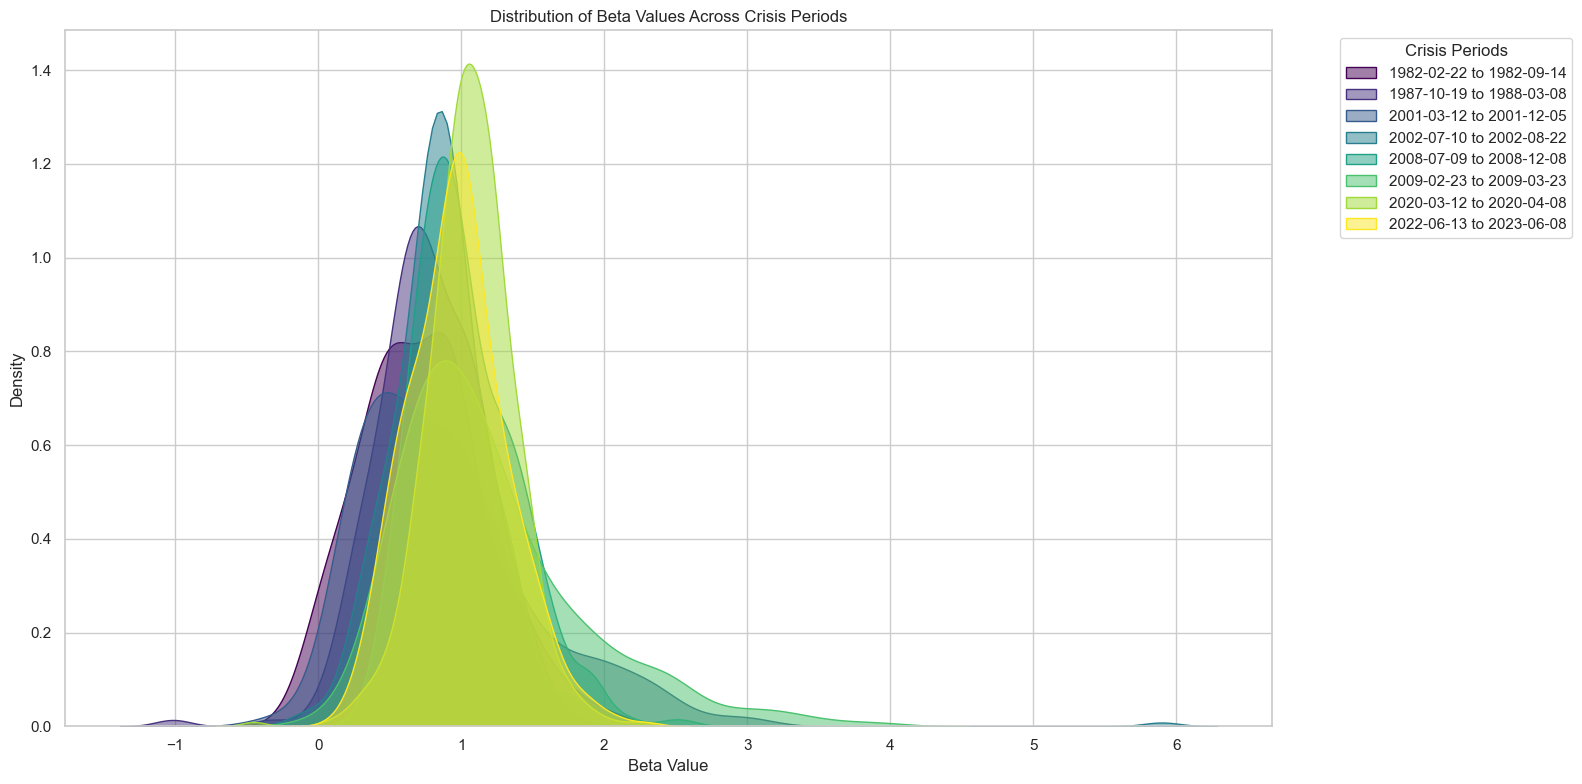

In [17]:
plt.figure(figsize=(16, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(crisis_periods)))

for i, (start_date, end_date) in enumerate(crisis_periods):
    
    beta_values = sp500.iloc[:, :-2].loc[start_date:end_date].apply(
        lambda x: x.cov(sp500['sp500_dr'].loc[start_date:end_date]) / sp500['sp500_dr'].loc[start_date:end_date].var()
    ).dropna()
    
    
    sns.kdeplot(beta_values, fill=True, alpha=0.5, color=colors[i], label=f'{start_date.date()} to {end_date.date()}')

title = "Distribution of Beta Values Across Crisis Periods"
xlabel = "Beta Value"

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel('Density')
plt.legend(title='Crisis Periods', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Weaknesses in our analysis

### Weaknesses we can't mitigatea* 2. Incomplete dat    + A. We analyze market in terms of SP500 which should have 500 stocks. But only 196 companies identified in our crisis of 1982 and roughly half in 1987 
+ii) The non-existent data in for our analysis might have helped us explain the correlations better* 2. Equal-weighted inde    + i) We assume SP500 to be equally weighted for all stocks it contain    +ii) In reality, SP500 is a market capitalization weighted inde    +ii) Not including this important distinction might have thrown-off the numbers in our analysi  


### Weakness we had and possible soluti* 
1. Covariance: Covariance measures how two stocks move together. During a crisis, if stocks react similarly by moving in the same direction, their covariance can increa s. However, certain sectors or stocks may be less impacted or even benefit from specific crises, like healthcare or tech stocks during relevant crises. In these cases, the covariance between these and more affected stocks might decrease or change unpredictably.
 + i) Although we have tried to incorporate covariance as a part of our analysis, the scope of the project follows correlation and Beta more closely.
 +ii) When covariance between one stock and market increases, it means that individual stock returns are more connected to how the overall market moves, showing the impact of the crisis affecting them a
3. 